In [1]:
def create_checkerboard(num_squares=2, square_size=1, margin=0, density=10000):
    # Total dimensions of the board
    total_size = num_squares * square_size
    # Initialize dataset
    data = []
    # Create checkerboard pattern
    for i in range(num_squares):
        for j in range(num_squares):
            # Determine the fill status (either filled or empty)
            if (i + j) % 2 == 0:  # Fill every other square
                # Center coordinates of the square
                center_x = i * square_size + square_size / 2 + margin
                center_y = j * square_size + square_size / 2 + margin
                # Generate points around the center
                points_x = center_x + (np.random.rand(density) - 0.5) * square_size
                points_y = center_y + (np.random.rand(density) - 0.5) * square_size
                # Add points to data
                data.append(np.stack([points_x, points_y], axis=1))
    # Convert list of arrays into a single numpy array
    data = np.concatenate(data, axis=0)
    return data - num_squares/2.0

def create_gaussian_checkerboard(num_squares=2, square_size=1, margin=0, density=10000, std_dev=0.25):
    # Total dimensions of the board
    total_size = num_squares * square_size
    # Initialize dataset
    data = []
    # Create checkerboard pattern
    for i in range(num_squares):
        for j in range(num_squares):
            # Determine the fill status (either filled or empty)
            if (i + j) % 2 == 0:  # Fill every other square
                # Center coordinates of the square
                center_x = i * square_size + square_size / 2 + margin
                center_y = j * square_size + square_size / 2 + margin
                # Generate points around the center with Gaussian distribution
                points_x = np.random.normal(center_x, std_dev, density)
                points_y = np.random.normal(center_y, std_dev, density)
                # Add points to data
                data.append(np.stack([points_x, points_y], axis=1))
    # Convert list of arrays into a single numpy array
    data = np.concatenate(data, axis=0)
    return data - num_squares/2.0

In [2]:
import torch
import numpy as np
import math

# Parameters
T = 100  # Number of time steps
N = 40000  # Number of paths
dt = 1.0 / T
b = torch.atan(torch.exp(torch.tensor(-10)))
a = torch.atan(torch.exp(torch.tensor(10))) - b
theta = lambda t: torch.tensor(10) * t + torch.tensor(0.01) * (1-t) #a * torch.tan(a*t + b) # np.log(1.01 * (1-t) + 10 * t)
mu = lambda t: 0
sigma = lambda t: torch.sqrt(2*theta(t))

# Time vector
time_vector = torch.linspace(0, 1, T)

initial_samples = torch.from_numpy(create_gaussian_checkerboard(num_squares=2, density=10000))

# Shuffle initial samples
N = initial_samples.shape[0]
perm = torch.randperm(N)
initial_samples = initial_samples[perm]

# Simulate the 2D OU process
brownian_motion = torch.zeros(N, T, 2)
bm_increments = torch.zeros(N, T, 2)
dynamics = torch.zeros(N, T, 2)
dynamics[:, 0, :] = initial_samples
params = torch.zeros(N, T, 2)
params[:, 0, 0] = theta(0)
params[:, 0, 1] = sigma(0)

for i in range(1, T):
    bm_increments[:, i] = torch.sqrt(torch.tensor(dt)) * torch.randn(N, 2)
    brownian_motion[:, i] = brownian_motion[:, i-1] + bm_increments[:, i-1]
    dynamics[:, i] = dynamics[:, i-1] + theta((i-1)/T) * (mu((i-1)/T) - dynamics[:, i-1]) * dt + sigma((i-1)/T) * bm_increments[:, i-1]
    params[:, i, 0] = theta((i-1)/T)
    params[:, i, 1] = sigma((i-1)/T)

# Preparing the tensors
time_tensor = time_vector.repeat(N, 1)
process_tensor = torch.cat([time_tensor[:, :, None], brownian_motion, bm_increments], dim=2)#.permute(1, 0, 2)
dynamics_tensor = dynamics#.permute(1, 0, 2)

# Extract the end time dynamics (at time T-1, which corresponds to time 1 in the simulation)
end_time_dynamics = dynamics[:, -1, :].unsqueeze(1).repeat(1, T, 1)

# Append the end time dynamics to the process tensor
process_tensor = torch.cat([process_tensor, end_time_dynamics, params], dim=2)
#process_tensor = torch.cat([process_tensor, end_time_dynamics], dim=2)
print("Updated process tensor shape:", process_tensor.shape)
print("Dynamics tensor shape:", dynamics_tensor.shape)

Updated process tensor shape: torch.Size([20000, 100, 9])
Dynamics tensor shape: torch.Size([20000, 100, 2])


[0, 3, 6, 12, 25, 50, 75, 99]


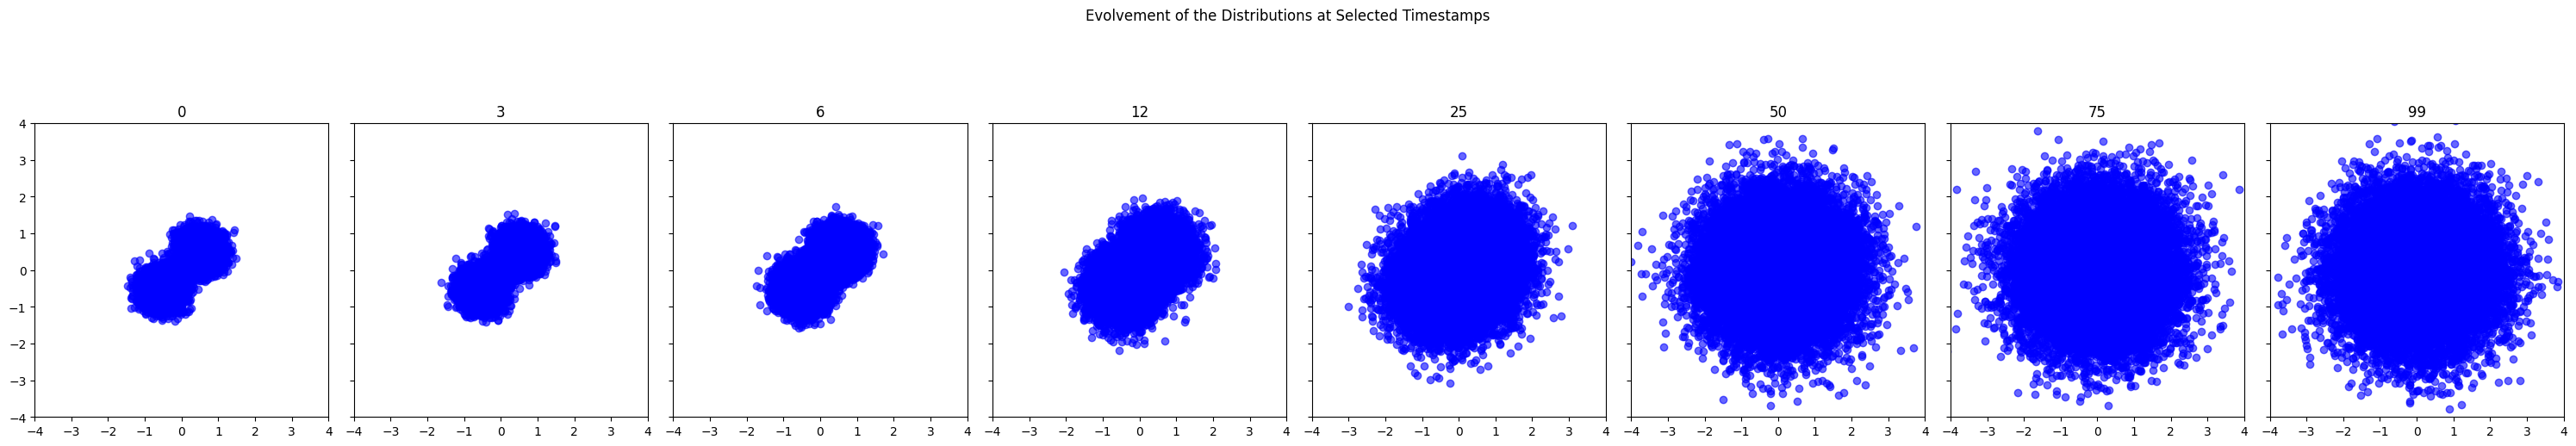

In [3]:
import matplotlib.pyplot as plt

# Select timestamps to visualize
selected_timestamps = [0, T//32, T//16, T//8, T//4, 2*T//4, 3*T//4, T-1]
selected_times = [time_vector[t].item() for t in selected_timestamps]

# Extract the data for the selected timestamps
subset_data = dynamics_tensor[:, selected_timestamps, :]
print(selected_timestamps)
# Plotting the distributions
fig, axs = plt.subplots(1, len(selected_timestamps), figsize=(30, 6), sharey=True)

for i, (ax, t, time) in enumerate(zip(axs, selected_timestamps, selected_times)):
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title(f"{t}")
    ax.scatter(subset_data[:, i, 0].numpy(), subset_data[:, i, 1].numpy(), color='blue', alpha=0.6)
    ax.set_aspect('equal')  # This makes the x and y axes of equal lengths

plt.suptitle('Evolvement of the Distributions at Selected Timestamps')
plt.tight_layout()
plt.show()


In [4]:
final_state = dynamics_tensor[:, -1, :]
final_state.mean(), final_state.permute(1, 0).cov()

(tensor(0.0019),
 tensor([[ 1.0489, -0.0029],
         [-0.0029,  1.0490]]))

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class OUDataset(Dataset):
    def __init__(self, process_tensor, dynamics_tensor):
        """
        Initializes the dataset with the process and dynamics tensors.
        :param process_tensor: Tensor containing timestamps, Brownian motion, and increments.
        :param dynamics_tensor: Tensor containing the dynamics of the OU process.
        """
        self.process_tensor = process_tensor
        self.dynamics_tensor = dynamics_tensor
        self.downsample = None

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.process_tensor.shape[0]

    def __getitem__(self, idx):
        """
        Retrieves the process and dynamics tensors for the given index.
        :param idx: Index of the desired sample.
        :return: A dictionary with keys 'x' and 'y'.
        """
        x = self.process_tensor[idx]
        y = self.dynamics_tensor[idx]
        if self.downsample is None:
            return {'x': x.permute(1, 0), 'y': y.permute(1, 0)}
        return {'x': x.permute(1, 0)[self.downsample, :], 'y': y.permute(1, 0)[self.downsample, :]}

# Assuming the previously defined process_tensor and dynamics_tensor are available
dataset = OUDataset(process_tensor, dynamics_tensor)

In [6]:
from torch.utils.data import random_split

# Total number of samples in the dataset
total_samples = len(dataset)

# Define the size of the train and test sets
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Perform the train-test split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# use a lower resolution for training
# train_dataset.downsample = [0, T//32, T//16, T//8, T//4, 2*T//4, 3*T//4, T-1]

# Creating DataLoaders for both train and test sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

# Quick check of DataLoader outputs
for data in train_loader:
    print("Train sample 'x' shape:", data['x'].shape)
    print("Train sample 'y' shape:", data['y'].shape)
    break  # Showing only the first batch from the training set

for data in test_loader:
    print("Test sample 'x' shape:", data['x'].shape)
    print("Test sample 'y' shape:", data['y'].shape)
    break  # Showing only the first batch from the testing set

Train sample 'x' shape: torch.Size([256, 9, 100])
Train sample 'y' shape: torch.Size([256, 2, 100])
Test sample 'x' shape: torch.Size([4000, 9, 100])
Test sample 'y' shape: torch.Size([4000, 2, 100])


In [13]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, TFNO1d
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cuda:1'

# We create a tensorized FNO model

model = TFNO1d(
    n_modes_height=24,
    in_channels=9,
    out_channels=2,
    hidden_channels=128,
    projection_channels=128,
    n_layers=32,
    factorization='dense',
    norm = "group_norm",
    rank=1.0,  # TODO: what does this parameter mean? set it to 1 seems problematic but set it to 1.0 seems good
    use_mlp=True # Default is False 
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


# %%
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-3, 
                                weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# %%
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


# %%


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


# %% 
# Create the trainer
trainer = Trainer(model=model,
                  n_epochs=400,
                  device=device,
                  data_processor=None, #data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)


# %%
# Actually train the model on our small Darcy-Flow dataset

trainer.train(train_loader=train_loader,
              test_loaders={50: test_loader, 100: test_loader},
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)


Our model has 14763010 parameters.

### MODEL ###
 TFNO1d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-31): 32 x ComplexDenseTensor(shape=torch.Size([128, 128, 13]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-31): 32 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (mlp): ModuleList(
      (0-31): 32 x MLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (mlp_skips): ModuleList(
      (0-31): 32 x SoftGating()
    )
    (norm): ModuleList(
      (0-63): 64 x GroupNorm(1, 128, eps=1e-05, affine=True)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(9, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0)

  0%|          | 0/400 [00:07<?, ?it/s]

Epoch 1/400: train_err=124.2883, avg_loss=0.4894, avg_lasso_loss=0.0000


  0%|          | 2/400 [00:15<49:35,  7.48s/it]

Epoch 2/400: train_err=52.1809, avg_loss=0.2055, avg_lasso_loss=0.0000


  1%|          | 3/400 [00:22<47:50,  7.23s/it]

Epoch 3/400: train_err=48.9210, avg_loss=0.1926, avg_lasso_loss=0.0000


  1%|          | 3/400 [00:29<47:50,  7.23s/it]

Epoch 4/400: train_err=48.4711, avg_loss=0.1909, avg_lasso_loss=0.0000


  1%|▏         | 5/400 [00:37<48:20,  7.34s/it]

Epoch 5/400: train_err=48.3529, avg_loss=0.1904, avg_lasso_loss=0.0000


  2%|▏         | 6/400 [00:44<47:19,  7.21s/it]

Epoch 6/400: train_err=47.6708, avg_loss=0.1877, avg_lasso_loss=0.0000


  2%|▏         | 6/400 [00:51<47:19,  7.21s/it]

Epoch 7/400: train_err=46.7552, avg_loss=0.1841, avg_lasso_loss=0.0000


  2%|▏         | 8/400 [00:59<48:01,  7.35s/it]

Epoch 8/400: train_err=46.3490, avg_loss=0.1825, avg_lasso_loss=0.0000


  2%|▏         | 9/400 [01:06<47:04,  7.22s/it]

Epoch 9/400: train_err=46.6913, avg_loss=0.1838, avg_lasso_loss=0.0000


  2%|▏         | 9/400 [01:13<47:04,  7.22s/it]

Epoch 10/400: train_err=46.4161, avg_loss=0.1828, avg_lasso_loss=0.0000


  3%|▎         | 11/400 [01:21<47:27,  7.32s/it]

Epoch 11/400: train_err=46.1897, avg_loss=0.1819, avg_lasso_loss=0.0000


  3%|▎         | 12/400 [01:28<46:34,  7.20s/it]

Epoch 12/400: train_err=45.9816, avg_loss=0.1811, avg_lasso_loss=0.0000


  3%|▎         | 12/400 [01:35<46:34,  7.20s/it]

Epoch 13/400: train_err=45.8968, avg_loss=0.1807, avg_lasso_loss=0.0000


  4%|▎         | 14/400 [01:43<47:14,  7.34s/it]

Epoch 14/400: train_err=45.5268, avg_loss=0.1793, avg_lasso_loss=0.0000


  4%|▍         | 15/400 [01:50<46:19,  7.22s/it]

Epoch 15/400: train_err=45.3123, avg_loss=0.1784, avg_lasso_loss=0.0000


  4%|▍         | 15/400 [01:57<46:19,  7.22s/it]

Epoch 16/400: train_err=45.3022, avg_loss=0.1784, avg_lasso_loss=0.0000


  4%|▍         | 17/400 [02:05<46:46,  7.33s/it]

Epoch 17/400: train_err=45.0460, avg_loss=0.1774, avg_lasso_loss=0.0000


  4%|▍         | 18/400 [02:12<45:54,  7.21s/it]

Epoch 18/400: train_err=44.9290, avg_loss=0.1769, avg_lasso_loss=0.0000


  4%|▍         | 18/400 [02:19<45:54,  7.21s/it]

Epoch 19/400: train_err=44.6550, avg_loss=0.1758, avg_lasso_loss=0.0000


  5%|▌         | 20/400 [02:27<46:18,  7.31s/it]

Epoch 20/400: train_err=44.6404, avg_loss=0.1758, avg_lasso_loss=0.0000


  5%|▌         | 21/400 [02:34<45:29,  7.20s/it]

Epoch 21/400: train_err=44.6224, avg_loss=0.1757, avg_lasso_loss=0.0000


  5%|▌         | 21/400 [02:41<45:29,  7.20s/it]

Epoch 22/400: train_err=44.3324, avg_loss=0.1746, avg_lasso_loss=0.0000


  6%|▌         | 23/400 [02:49<46:06,  7.34s/it]

Epoch 23/400: train_err=44.1010, avg_loss=0.1736, avg_lasso_loss=0.0000


  6%|▌         | 24/400 [02:56<45:13,  7.22s/it]

Epoch 24/400: train_err=43.9217, avg_loss=0.1729, avg_lasso_loss=0.0000


  6%|▌         | 24/400 [03:03<45:13,  7.22s/it]

Epoch 25/400: train_err=43.7906, avg_loss=0.1724, avg_lasso_loss=0.0000


  6%|▋         | 26/400 [03:11<45:35,  7.31s/it]

Epoch 26/400: train_err=43.6997, avg_loss=0.1721, avg_lasso_loss=0.0000


  7%|▋         | 27/400 [03:18<44:45,  7.20s/it]

Epoch 27/400: train_err=43.5540, avg_loss=0.1715, avg_lasso_loss=0.0000


  7%|▋         | 27/400 [03:25<44:45,  7.20s/it]

Epoch 28/400: train_err=43.4828, avg_loss=0.1712, avg_lasso_loss=0.0000


  7%|▋         | 29/400 [03:33<45:10,  7.31s/it]

Epoch 29/400: train_err=43.4260, avg_loss=0.1710, avg_lasso_loss=0.0000


  8%|▊         | 30/400 [03:40<44:41,  7.25s/it]

Epoch 30/400: train_err=43.3852, avg_loss=0.1708, avg_lasso_loss=0.0000


  8%|▊         | 30/400 [03:47<44:41,  7.25s/it]

Epoch 31/400: train_err=43.3700, avg_loss=0.1708, avg_lasso_loss=0.0000


  8%|▊         | 32/400 [03:55<44:55,  7.33s/it]

Epoch 32/400: train_err=43.3808, avg_loss=0.1708, avg_lasso_loss=0.0000


  8%|▊         | 33/400 [04:02<44:05,  7.21s/it]

Epoch 33/400: train_err=43.4112, avg_loss=0.1709, avg_lasso_loss=0.0000


  8%|▊         | 33/400 [04:09<44:05,  7.21s/it]

Epoch 34/400: train_err=43.4677, avg_loss=0.1712, avg_lasso_loss=0.0000


  9%|▉         | 35/400 [04:17<44:26,  7.31s/it]

Epoch 35/400: train_err=43.5105, avg_loss=0.1713, avg_lasso_loss=0.0000


  9%|▉         | 36/400 [04:24<43:38,  7.19s/it]

Epoch 36/400: train_err=43.5528, avg_loss=0.1715, avg_lasso_loss=0.0000


  9%|▉         | 36/400 [04:31<43:38,  7.19s/it]

Epoch 37/400: train_err=43.6127, avg_loss=0.1717, avg_lasso_loss=0.0000


 10%|▉         | 38/400 [04:39<44:15,  7.34s/it]

Epoch 38/400: train_err=43.7409, avg_loss=0.1722, avg_lasso_loss=0.0000


 10%|▉         | 39/400 [04:46<43:24,  7.21s/it]

Epoch 39/400: train_err=43.7985, avg_loss=0.1725, avg_lasso_loss=0.0000


 10%|▉         | 39/400 [04:53<43:24,  7.21s/it]

Epoch 40/400: train_err=44.0187, avg_loss=0.1733, avg_lasso_loss=0.0000


 10%|█         | 41/400 [05:01<43:46,  7.32s/it]

Epoch 41/400: train_err=43.8635, avg_loss=0.1727, avg_lasso_loss=0.0000


 10%|█         | 42/400 [05:08<42:58,  7.20s/it]

Epoch 42/400: train_err=44.1230, avg_loss=0.1737, avg_lasso_loss=0.0000


 10%|█         | 42/400 [05:15<42:58,  7.20s/it]

Epoch 43/400: train_err=44.1999, avg_loss=0.1740, avg_lasso_loss=0.0000


 11%|█         | 44/400 [05:23<43:21,  7.31s/it]

Epoch 44/400: train_err=44.2212, avg_loss=0.1741, avg_lasso_loss=0.0000


 11%|█▏        | 45/400 [05:30<42:35,  7.20s/it]

Epoch 45/400: train_err=44.2676, avg_loss=0.1743, avg_lasso_loss=0.0000


 11%|█▏        | 45/400 [05:37<42:35,  7.20s/it]

Epoch 46/400: train_err=44.3348, avg_loss=0.1746, avg_lasso_loss=0.0000


 12%|█▏        | 47/400 [05:45<43:12,  7.34s/it]

Epoch 47/400: train_err=44.1264, avg_loss=0.1737, avg_lasso_loss=0.0000


 12%|█▏        | 48/400 [05:52<42:22,  7.22s/it]

Epoch 48/400: train_err=44.5395, avg_loss=0.1754, avg_lasso_loss=0.0000


 12%|█▏        | 48/400 [05:59<42:22,  7.22s/it]

Epoch 49/400: train_err=44.4980, avg_loss=0.1752, avg_lasso_loss=0.0000


 12%|█▎        | 50/400 [06:07<42:41,  7.32s/it]

Epoch 50/400: train_err=44.1179, avg_loss=0.1737, avg_lasso_loss=0.0000


 13%|█▎        | 51/400 [06:14<41:54,  7.21s/it]

Epoch 51/400: train_err=43.3863, avg_loss=0.1708, avg_lasso_loss=0.0000


 13%|█▎        | 51/400 [06:21<41:54,  7.21s/it]

Epoch 52/400: train_err=43.8512, avg_loss=0.1727, avg_lasso_loss=0.0000


 13%|█▎        | 53/400 [06:29<42:18,  7.31s/it]

Epoch 53/400: train_err=42.4681, avg_loss=0.1672, avg_lasso_loss=0.0000


 14%|█▎        | 54/400 [06:36<41:46,  7.24s/it]

Epoch 54/400: train_err=42.3543, avg_loss=0.1668, avg_lasso_loss=0.0000


 14%|█▎        | 54/400 [06:43<41:46,  7.24s/it]

Epoch 55/400: train_err=41.3179, avg_loss=0.1627, avg_lasso_loss=0.0000


 14%|█▍        | 56/400 [06:51<42:00,  7.33s/it]

Epoch 56/400: train_err=40.6339, avg_loss=0.1600, avg_lasso_loss=0.0000


 14%|█▍        | 57/400 [06:58<41:16,  7.22s/it]

Epoch 57/400: train_err=40.1600, avg_loss=0.1581, avg_lasso_loss=0.0000


 14%|█▍        | 57/400 [07:05<41:16,  7.22s/it]

Epoch 58/400: train_err=38.7840, avg_loss=0.1527, avg_lasso_loss=0.0000


 15%|█▍        | 59/400 [07:13<41:35,  7.32s/it]

Epoch 59/400: train_err=36.7646, avg_loss=0.1448, avg_lasso_loss=0.0000


 15%|█▌        | 60/400 [07:20<40:49,  7.20s/it]

Epoch 60/400: train_err=34.7320, avg_loss=0.1368, avg_lasso_loss=0.0000


 15%|█▌        | 60/400 [07:27<40:49,  7.20s/it]

Epoch 61/400: train_err=32.4776, avg_loss=0.1279, avg_lasso_loss=0.0000


 16%|█▌        | 62/400 [07:35<41:20,  7.34s/it]

Epoch 62/400: train_err=31.2884, avg_loss=0.1232, avg_lasso_loss=0.0000


 16%|█▌        | 63/400 [07:42<40:31,  7.22s/it]

Epoch 63/400: train_err=28.8415, avg_loss=0.1136, avg_lasso_loss=0.0000


 16%|█▌        | 63/400 [07:49<40:31,  7.22s/it]

Epoch 64/400: train_err=26.4256, avg_loss=0.1041, avg_lasso_loss=0.0000


 16%|█▋        | 65/400 [07:57<40:49,  7.31s/it]

Epoch 65/400: train_err=24.3374, avg_loss=0.0958, avg_lasso_loss=0.0000


 16%|█▋        | 66/400 [08:04<40:05,  7.20s/it]

Epoch 66/400: train_err=24.1791, avg_loss=0.0952, avg_lasso_loss=0.0000


 16%|█▋        | 66/400 [08:11<40:05,  7.20s/it]

Epoch 67/400: train_err=21.4789, avg_loss=0.0846, avg_lasso_loss=0.0000


 17%|█▋        | 68/400 [08:19<40:26,  7.31s/it]

Epoch 68/400: train_err=20.2618, avg_loss=0.0798, avg_lasso_loss=0.0000


 17%|█▋        | 69/400 [08:26<39:57,  7.24s/it]

Epoch 69/400: train_err=19.5237, avg_loss=0.0769, avg_lasso_loss=0.0000


 17%|█▋        | 69/400 [08:33<39:57,  7.24s/it]

Epoch 70/400: train_err=18.4323, avg_loss=0.0726, avg_lasso_loss=0.0000


 18%|█▊        | 71/400 [08:41<40:11,  7.33s/it]

Epoch 71/400: train_err=17.6182, avg_loss=0.0694, avg_lasso_loss=0.0000


 18%|█▊        | 72/400 [08:48<39:25,  7.21s/it]

Epoch 72/400: train_err=17.0671, avg_loss=0.0672, avg_lasso_loss=0.0000


 18%|█▊        | 72/400 [08:55<39:25,  7.21s/it]

Epoch 73/400: train_err=16.2615, avg_loss=0.0640, avg_lasso_loss=0.0000


 18%|█▊        | 74/400 [09:03<39:43,  7.31s/it]

Epoch 74/400: train_err=15.6072, avg_loss=0.0615, avg_lasso_loss=0.0000


 19%|█▉        | 75/400 [09:10<39:00,  7.20s/it]

Epoch 75/400: train_err=15.0179, avg_loss=0.0591, avg_lasso_loss=0.0000


 19%|█▉        | 75/400 [09:17<39:00,  7.20s/it]

Epoch 76/400: train_err=14.6786, avg_loss=0.0578, avg_lasso_loss=0.0000


 19%|█▉        | 77/400 [09:25<39:30,  7.34s/it]

Epoch 77/400: train_err=13.8624, avg_loss=0.0546, avg_lasso_loss=0.0000


 20%|█▉        | 78/400 [09:32<38:46,  7.22s/it]

Epoch 78/400: train_err=13.4753, avg_loss=0.0531, avg_lasso_loss=0.0000


 20%|█▉        | 78/400 [09:39<38:46,  7.22s/it]

Epoch 79/400: train_err=13.2743, avg_loss=0.0523, avg_lasso_loss=0.0000


 20%|██        | 80/400 [09:47<39:01,  7.32s/it]

Epoch 80/400: train_err=12.6247, avg_loss=0.0497, avg_lasso_loss=0.0000


 20%|██        | 81/400 [09:54<38:18,  7.20s/it]

Epoch 81/400: train_err=12.2587, avg_loss=0.0483, avg_lasso_loss=0.0000


 20%|██        | 81/400 [10:01<38:18,  7.20s/it]

Epoch 82/400: train_err=11.9598, avg_loss=0.0471, avg_lasso_loss=0.0000


 21%|██        | 83/400 [10:09<38:37,  7.31s/it]

Epoch 83/400: train_err=11.7438, avg_loss=0.0462, avg_lasso_loss=0.0000


 21%|██        | 84/400 [10:16<37:54,  7.20s/it]

Epoch 84/400: train_err=11.5320, avg_loss=0.0454, avg_lasso_loss=0.0000


 21%|██        | 84/400 [10:23<37:54,  7.20s/it]

Epoch 85/400: train_err=11.3713, avg_loss=0.0448, avg_lasso_loss=0.0000


 22%|██▏       | 86/400 [10:31<38:27,  7.35s/it]

Epoch 86/400: train_err=11.2419, avg_loss=0.0443, avg_lasso_loss=0.0000


 22%|██▏       | 87/400 [10:38<37:41,  7.22s/it]

Epoch 87/400: train_err=11.1639, avg_loss=0.0440, avg_lasso_loss=0.0000


 22%|██▏       | 87/400 [10:45<37:41,  7.22s/it]

Epoch 88/400: train_err=11.1096, avg_loss=0.0437, avg_lasso_loss=0.0000


 22%|██▏       | 89/400 [10:53<37:56,  7.32s/it]

Epoch 89/400: train_err=11.0784, avg_loss=0.0436, avg_lasso_loss=0.0000


 22%|██▎       | 90/400 [11:00<37:14,  7.21s/it]

Epoch 90/400: train_err=11.0587, avg_loss=0.0435, avg_lasso_loss=0.0000


 22%|██▎       | 90/400 [11:07<37:14,  7.21s/it]

Epoch 91/400: train_err=11.0521, avg_loss=0.0435, avg_lasso_loss=0.0000


 23%|██▎       | 92/400 [11:15<37:32,  7.31s/it]

Epoch 92/400: train_err=11.0550, avg_loss=0.0435, avg_lasso_loss=0.0000


 23%|██▎       | 93/400 [11:22<36:50,  7.20s/it]

Epoch 93/400: train_err=11.0630, avg_loss=0.0436, avg_lasso_loss=0.0000


 23%|██▎       | 93/400 [11:29<36:50,  7.20s/it]

Epoch 94/400: train_err=11.0673, avg_loss=0.0436, avg_lasso_loss=0.0000


 24%|██▍       | 95/400 [11:37<37:18,  7.34s/it]

Epoch 95/400: train_err=11.0663, avg_loss=0.0436, avg_lasso_loss=0.0000


 24%|██▍       | 96/400 [11:44<36:34,  7.22s/it]

Epoch 96/400: train_err=11.0772, avg_loss=0.0436, avg_lasso_loss=0.0000


 24%|██▍       | 96/400 [11:51<36:34,  7.22s/it]

Epoch 97/400: train_err=11.0606, avg_loss=0.0436, avg_lasso_loss=0.0000


 24%|██▍       | 98/400 [11:59<36:52,  7.32s/it]

Epoch 98/400: train_err=11.0894, avg_loss=0.0437, avg_lasso_loss=0.0000


 25%|██▍       | 99/400 [12:06<36:10,  7.21s/it]

Epoch 99/400: train_err=11.1849, avg_loss=0.0440, avg_lasso_loss=0.0000


 25%|██▍       | 99/400 [12:13<36:10,  7.21s/it]

Epoch 100/400: train_err=11.3471, avg_loss=0.0447, avg_lasso_loss=0.0000


 25%|██▌       | 101/400 [12:22<36:36,  7.35s/it]

Epoch 101/400: train_err=11.8030, avg_loss=0.0465, avg_lasso_loss=0.0000


 26%|██▌       | 102/400 [12:28<35:54,  7.23s/it]

Epoch 102/400: train_err=12.1583, avg_loss=0.0479, avg_lasso_loss=0.0000


 26%|██▌       | 102/400 [12:35<35:54,  7.23s/it]

Epoch 103/400: train_err=12.5582, avg_loss=0.0494, avg_lasso_loss=0.0000


 26%|██▌       | 104/400 [12:44<36:07,  7.32s/it]

Epoch 104/400: train_err=12.7783, avg_loss=0.0503, avg_lasso_loss=0.0000


 26%|██▋       | 105/400 [12:50<35:26,  7.21s/it]

Epoch 105/400: train_err=13.3925, avg_loss=0.0527, avg_lasso_loss=0.0000


 26%|██▋       | 105/400 [12:57<35:26,  7.21s/it]

Epoch 106/400: train_err=13.6759, avg_loss=0.0538, avg_lasso_loss=0.0000


 27%|██▋       | 107/400 [13:05<35:41,  7.31s/it]

Epoch 107/400: train_err=13.6895, avg_loss=0.0539, avg_lasso_loss=0.0000


 27%|██▋       | 108/400 [13:12<35:02,  7.20s/it]

Epoch 108/400: train_err=14.0342, avg_loss=0.0553, avg_lasso_loss=0.0000


 27%|██▋       | 108/400 [13:19<35:02,  7.20s/it]

Epoch 109/400: train_err=13.8000, avg_loss=0.0543, avg_lasso_loss=0.0000


 28%|██▊       | 110/400 [13:28<35:27,  7.34s/it]

Epoch 110/400: train_err=14.6085, avg_loss=0.0575, avg_lasso_loss=0.0000


 28%|██▊       | 111/400 [13:35<34:45,  7.22s/it]

Epoch 111/400: train_err=13.9268, avg_loss=0.0548, avg_lasso_loss=0.0000


 28%|██▊       | 111/400 [13:41<34:45,  7.22s/it]

Epoch 112/400: train_err=14.0178, avg_loss=0.0552, avg_lasso_loss=0.0000


 28%|██▊       | 113/400 [13:50<34:59,  7.31s/it]

Epoch 113/400: train_err=14.1090, avg_loss=0.0556, avg_lasso_loss=0.0000


 28%|██▊       | 114/400 [13:56<34:21,  7.21s/it]

Epoch 114/400: train_err=14.3905, avg_loss=0.0567, avg_lasso_loss=0.0000


 28%|██▊       | 114/400 [14:03<34:21,  7.21s/it]

Epoch 115/400: train_err=14.0739, avg_loss=0.0554, avg_lasso_loss=0.0000


 29%|██▉       | 116/400 [14:12<34:47,  7.35s/it]

Epoch 116/400: train_err=13.8191, avg_loss=0.0544, avg_lasso_loss=0.0000


 29%|██▉       | 117/400 [14:19<34:05,  7.23s/it]

Epoch 117/400: train_err=13.1834, avg_loss=0.0519, avg_lasso_loss=0.0000


 29%|██▉       | 117/400 [14:26<34:05,  7.23s/it]

Epoch 118/400: train_err=13.0141, avg_loss=0.0512, avg_lasso_loss=0.0000


 30%|██▉       | 119/400 [14:34<34:17,  7.32s/it]

Epoch 119/400: train_err=13.1070, avg_loss=0.0516, avg_lasso_loss=0.0000


 30%|███       | 120/400 [14:41<33:37,  7.21s/it]

Epoch 120/400: train_err=12.2098, avg_loss=0.0481, avg_lasso_loss=0.0000


 30%|███       | 120/400 [14:47<33:37,  7.21s/it]

Epoch 121/400: train_err=11.7586, avg_loss=0.0463, avg_lasso_loss=0.0000


 30%|███       | 122/400 [14:56<33:52,  7.31s/it]

Epoch 122/400: train_err=11.8175, avg_loss=0.0465, avg_lasso_loss=0.0000


 31%|███       | 123/400 [15:02<33:13,  7.20s/it]

Epoch 123/400: train_err=10.9911, avg_loss=0.0433, avg_lasso_loss=0.0000


 31%|███       | 123/400 [15:10<33:13,  7.20s/it]

Epoch 124/400: train_err=10.6370, avg_loss=0.0419, avg_lasso_loss=0.0000


 31%|███▏      | 125/400 [15:18<33:37,  7.34s/it]

Epoch 125/400: train_err=10.0915, avg_loss=0.0397, avg_lasso_loss=0.0000


 32%|███▏      | 126/400 [15:25<32:58,  7.22s/it]

Epoch 126/400: train_err=9.9713, avg_loss=0.0393, avg_lasso_loss=0.0000


 32%|███▏      | 126/400 [15:32<32:58,  7.22s/it]

Epoch 127/400: train_err=9.4743, avg_loss=0.0373, avg_lasso_loss=0.0000


 32%|███▏      | 128/400 [15:40<33:10,  7.32s/it]

Epoch 128/400: train_err=9.0473, avg_loss=0.0356, avg_lasso_loss=0.0000


 32%|███▏      | 129/400 [15:47<32:31,  7.20s/it]

Epoch 129/400: train_err=8.8736, avg_loss=0.0349, avg_lasso_loss=0.0000


 32%|███▏      | 129/400 [15:54<32:31,  7.20s/it]

Epoch 130/400: train_err=8.3591, avg_loss=0.0329, avg_lasso_loss=0.0000


 33%|███▎      | 131/400 [16:02<32:54,  7.34s/it]

Epoch 131/400: train_err=7.8672, avg_loss=0.0310, avg_lasso_loss=0.0000


 33%|███▎      | 132/400 [16:09<32:14,  7.22s/it]

Epoch 132/400: train_err=7.2534, avg_loss=0.0286, avg_lasso_loss=0.0000


 33%|███▎      | 132/400 [16:16<32:14,  7.22s/it]

Epoch 133/400: train_err=7.0410, avg_loss=0.0277, avg_lasso_loss=0.0000


 34%|███▎      | 134/400 [16:24<32:25,  7.31s/it]

Epoch 134/400: train_err=6.6258, avg_loss=0.0261, avg_lasso_loss=0.0000


 34%|███▍      | 135/400 [16:31<31:48,  7.20s/it]

Epoch 135/400: train_err=6.3047, avg_loss=0.0248, avg_lasso_loss=0.0000


 34%|███▍      | 135/400 [16:38<31:48,  7.20s/it]

Epoch 136/400: train_err=5.8421, avg_loss=0.0230, avg_lasso_loss=0.0000


 34%|███▍      | 137/400 [16:46<32:01,  7.31s/it]

Epoch 137/400: train_err=5.4827, avg_loss=0.0216, avg_lasso_loss=0.0000


 34%|███▍      | 138/400 [16:53<31:26,  7.20s/it]

Epoch 138/400: train_err=5.1532, avg_loss=0.0203, avg_lasso_loss=0.0000


 34%|███▍      | 138/400 [17:00<31:26,  7.20s/it]

Epoch 139/400: train_err=4.8902, avg_loss=0.0193, avg_lasso_loss=0.0000


 35%|███▌      | 140/400 [17:08<31:47,  7.34s/it]

Epoch 140/400: train_err=4.7004, avg_loss=0.0185, avg_lasso_loss=0.0000


 35%|███▌      | 141/400 [17:15<31:08,  7.22s/it]

Epoch 141/400: train_err=4.4379, avg_loss=0.0175, avg_lasso_loss=0.0000


 35%|███▌      | 141/400 [17:22<31:08,  7.22s/it]

Epoch 142/400: train_err=4.2708, avg_loss=0.0168, avg_lasso_loss=0.0000


 36%|███▌      | 143/400 [17:30<31:19,  7.31s/it]

Epoch 143/400: train_err=4.1534, avg_loss=0.0164, avg_lasso_loss=0.0000


 36%|███▌      | 144/400 [17:37<30:42,  7.20s/it]

Epoch 144/400: train_err=4.0777, avg_loss=0.0161, avg_lasso_loss=0.0000


 36%|███▌      | 144/400 [17:44<30:42,  7.20s/it]

Epoch 145/400: train_err=4.0261, avg_loss=0.0159, avg_lasso_loss=0.0000


 36%|███▋      | 146/400 [17:52<30:54,  7.30s/it]

Epoch 146/400: train_err=3.9946, avg_loss=0.0157, avg_lasso_loss=0.0000


 37%|███▋      | 147/400 [17:59<30:31,  7.24s/it]

Epoch 147/400: train_err=3.9713, avg_loss=0.0156, avg_lasso_loss=0.0000


 37%|███▋      | 147/400 [18:06<30:31,  7.24s/it]

Epoch 148/400: train_err=3.9576, avg_loss=0.0156, avg_lasso_loss=0.0000


 37%|███▋      | 149/400 [18:14<30:38,  7.32s/it]

Epoch 149/400: train_err=3.9494, avg_loss=0.0156, avg_lasso_loss=0.0000


 38%|███▊      | 150/400 [18:21<30:02,  7.21s/it]

Epoch 150/400: train_err=3.9447, avg_loss=0.0155, avg_lasso_loss=0.0000


 38%|███▊      | 150/400 [18:28<30:02,  7.21s/it]

Epoch 151/400: train_err=3.9434, avg_loss=0.0155, avg_lasso_loss=0.0000


 38%|███▊      | 152/400 [18:36<30:12,  7.31s/it]

Epoch 152/400: train_err=3.9439, avg_loss=0.0155, avg_lasso_loss=0.0000


 38%|███▊      | 153/400 [18:43<29:38,  7.20s/it]

Epoch 153/400: train_err=3.9451, avg_loss=0.0155, avg_lasso_loss=0.0000


 38%|███▊      | 153/400 [18:50<29:38,  7.20s/it]

Epoch 154/400: train_err=3.9453, avg_loss=0.0155, avg_lasso_loss=0.0000


 39%|███▉      | 155/400 [18:58<29:58,  7.34s/it]

Epoch 155/400: train_err=3.9430, avg_loss=0.0155, avg_lasso_loss=0.0000


 39%|███▉      | 156/400 [19:05<29:21,  7.22s/it]

Epoch 156/400: train_err=3.9393, avg_loss=0.0155, avg_lasso_loss=0.0000


 39%|███▉      | 156/400 [19:12<29:21,  7.22s/it]

Epoch 157/400: train_err=3.9291, avg_loss=0.0155, avg_lasso_loss=0.0000


 40%|███▉      | 158/400 [19:20<29:30,  7.31s/it]

Epoch 158/400: train_err=3.9209, avg_loss=0.0154, avg_lasso_loss=0.0000


 40%|███▉      | 159/400 [19:27<28:55,  7.20s/it]

Epoch 159/400: train_err=3.9837, avg_loss=0.0157, avg_lasso_loss=0.0000


 40%|███▉      | 159/400 [19:34<28:55,  7.20s/it]

Epoch 160/400: train_err=4.3767, avg_loss=0.0172, avg_lasso_loss=0.0000


 40%|████      | 161/400 [19:42<29:06,  7.31s/it]

Epoch 161/400: train_err=4.8376, avg_loss=0.0190, avg_lasso_loss=0.0000


 40%|████      | 162/400 [19:49<28:33,  7.20s/it]

Epoch 162/400: train_err=5.3695, avg_loss=0.0211, avg_lasso_loss=0.0000


 40%|████      | 162/400 [19:56<28:33,  7.20s/it]

Epoch 163/400: train_err=6.0309, avg_loss=0.0237, avg_lasso_loss=0.0000


 41%|████      | 164/400 [20:04<28:52,  7.34s/it]

Epoch 164/400: train_err=6.4667, avg_loss=0.0255, avg_lasso_loss=0.0000


 41%|████▏     | 165/400 [20:11<28:16,  7.22s/it]

Epoch 165/400: train_err=6.7148, avg_loss=0.0264, avg_lasso_loss=0.0000


 41%|████▏     | 165/400 [20:18<28:16,  7.22s/it]

Epoch 166/400: train_err=7.0321, avg_loss=0.0277, avg_lasso_loss=0.0000


 42%|████▏     | 167/400 [20:26<28:24,  7.32s/it]

Epoch 167/400: train_err=7.3164, avg_loss=0.0288, avg_lasso_loss=0.0000


 42%|████▏     | 168/400 [20:33<27:51,  7.20s/it]

Epoch 168/400: train_err=8.3167, avg_loss=0.0327, avg_lasso_loss=0.0000


 42%|████▏     | 168/400 [20:40<27:51,  7.20s/it]

Epoch 169/400: train_err=7.6855, avg_loss=0.0303, avg_lasso_loss=0.0000


 42%|████▎     | 170/400 [20:48<28:00,  7.31s/it]

Epoch 170/400: train_err=8.2102, avg_loss=0.0323, avg_lasso_loss=0.0000


 43%|████▎     | 171/400 [20:55<27:37,  7.24s/it]

Epoch 171/400: train_err=8.4252, avg_loss=0.0332, avg_lasso_loss=0.0000


 43%|████▎     | 171/400 [21:02<27:37,  7.24s/it]

Epoch 172/400: train_err=9.4194, avg_loss=0.0371, avg_lasso_loss=0.0000


 43%|████▎     | 173/400 [21:10<27:42,  7.32s/it]

Epoch 173/400: train_err=8.4472, avg_loss=0.0333, avg_lasso_loss=0.0000


 44%|████▎     | 174/400 [21:17<27:09,  7.21s/it]

Epoch 174/400: train_err=8.5022, avg_loss=0.0335, avg_lasso_loss=0.0000


 44%|████▎     | 174/400 [21:24<27:09,  7.21s/it]

Epoch 175/400: train_err=8.5233, avg_loss=0.0336, avg_lasso_loss=0.0000


 44%|████▍     | 176/400 [21:32<27:18,  7.31s/it]

Epoch 176/400: train_err=9.3759, avg_loss=0.0369, avg_lasso_loss=0.0000


 44%|████▍     | 177/400 [21:39<26:45,  7.20s/it]

Epoch 177/400: train_err=9.9759, avg_loss=0.0393, avg_lasso_loss=0.0000


 44%|████▍     | 177/400 [21:46<26:45,  7.20s/it]

Epoch 178/400: train_err=8.3449, avg_loss=0.0329, avg_lasso_loss=0.0000


 45%|████▍     | 179/400 [21:54<27:02,  7.34s/it]

Epoch 179/400: train_err=8.2622, avg_loss=0.0325, avg_lasso_loss=0.0000


 45%|████▌     | 180/400 [22:01<26:28,  7.22s/it]

Epoch 180/400: train_err=8.3717, avg_loss=0.0330, avg_lasso_loss=0.0000


 45%|████▌     | 180/400 [22:08<26:28,  7.22s/it]

Epoch 181/400: train_err=8.0405, avg_loss=0.0317, avg_lasso_loss=0.0000


 46%|████▌     | 182/400 [22:16<26:34,  7.31s/it]

Epoch 182/400: train_err=7.8177, avg_loss=0.0308, avg_lasso_loss=0.0000


 46%|████▌     | 183/400 [22:23<26:02,  7.20s/it]

Epoch 183/400: train_err=10.7100, avg_loss=0.0422, avg_lasso_loss=0.0000


 46%|████▌     | 183/400 [22:30<26:02,  7.20s/it]

Epoch 184/400: train_err=7.3500, avg_loss=0.0289, avg_lasso_loss=0.0000


 46%|████▋     | 185/400 [22:38<26:10,  7.31s/it]

Epoch 185/400: train_err=7.2914, avg_loss=0.0287, avg_lasso_loss=0.0000


 46%|████▋     | 186/400 [22:45<25:49,  7.24s/it]

Epoch 186/400: train_err=7.9160, avg_loss=0.0312, avg_lasso_loss=0.0000


 46%|████▋     | 186/400 [22:52<25:49,  7.24s/it]

Epoch 187/400: train_err=6.5638, avg_loss=0.0258, avg_lasso_loss=0.0000


 47%|████▋     | 188/400 [23:00<25:53,  7.33s/it]

Epoch 188/400: train_err=6.3883, avg_loss=0.0252, avg_lasso_loss=0.0000


 47%|████▋     | 189/400 [23:07<25:21,  7.21s/it]

Epoch 189/400: train_err=5.9960, avg_loss=0.0236, avg_lasso_loss=0.0000


 47%|████▋     | 189/400 [23:14<25:21,  7.21s/it]

Epoch 190/400: train_err=5.8144, avg_loss=0.0229, avg_lasso_loss=0.0000


 48%|████▊     | 191/400 [23:22<25:27,  7.31s/it]

Epoch 191/400: train_err=5.7156, avg_loss=0.0225, avg_lasso_loss=0.0000


 48%|████▊     | 192/400 [23:29<24:56,  7.20s/it]

Epoch 192/400: train_err=5.3630, avg_loss=0.0211, avg_lasso_loss=0.0000


 48%|████▊     | 192/400 [23:36<24:56,  7.20s/it]

Epoch 193/400: train_err=4.7145, avg_loss=0.0186, avg_lasso_loss=0.0000


 48%|████▊     | 194/400 [23:44<25:11,  7.34s/it]

Epoch 194/400: train_err=4.7632, avg_loss=0.0188, avg_lasso_loss=0.0000


 49%|████▉     | 195/400 [23:51<24:39,  7.22s/it]

Epoch 195/400: train_err=6.1205, avg_loss=0.0241, avg_lasso_loss=0.0000


 49%|████▉     | 195/400 [23:58<24:39,  7.22s/it]

Epoch 196/400: train_err=4.2348, avg_loss=0.0167, avg_lasso_loss=0.0000


 49%|████▉     | 197/400 [24:06<24:44,  7.31s/it]

Epoch 197/400: train_err=3.7628, avg_loss=0.0148, avg_lasso_loss=0.0000


 50%|████▉     | 198/400 [24:13<24:14,  7.20s/it]

Epoch 198/400: train_err=3.5108, avg_loss=0.0138, avg_lasso_loss=0.0000


 50%|████▉     | 198/400 [24:20<24:14,  7.20s/it]

Epoch 199/400: train_err=3.2841, avg_loss=0.0129, avg_lasso_loss=0.0000


 50%|█████     | 200/400 [24:28<24:20,  7.30s/it]

Epoch 200/400: train_err=3.1019, avg_loss=0.0122, avg_lasso_loss=0.0000


 50%|█████     | 201/400 [24:35<23:51,  7.19s/it]

Epoch 201/400: train_err=2.9566, avg_loss=0.0116, avg_lasso_loss=0.0000


 50%|█████     | 201/400 [24:42<23:51,  7.19s/it]

Epoch 202/400: train_err=2.8626, avg_loss=0.0113, avg_lasso_loss=0.0000


 51%|█████     | 203/400 [24:50<24:04,  7.33s/it]

Epoch 203/400: train_err=2.7925, avg_loss=0.0110, avg_lasso_loss=0.0000


 51%|█████     | 204/400 [24:57<23:34,  7.21s/it]

Epoch 204/400: train_err=2.7440, avg_loss=0.0108, avg_lasso_loss=0.0000


 51%|█████     | 204/400 [25:04<23:34,  7.21s/it]

Epoch 205/400: train_err=2.7112, avg_loss=0.0107, avg_lasso_loss=0.0000


 52%|█████▏    | 206/400 [25:12<23:38,  7.31s/it]

Epoch 206/400: train_err=2.6894, avg_loss=0.0106, avg_lasso_loss=0.0000


 52%|█████▏    | 207/400 [25:19<23:09,  7.20s/it]

Epoch 207/400: train_err=2.6753, avg_loss=0.0105, avg_lasso_loss=0.0000


 52%|█████▏    | 207/400 [25:26<23:09,  7.20s/it]

Epoch 208/400: train_err=2.6662, avg_loss=0.0105, avg_lasso_loss=0.0000


 52%|█████▏    | 209/400 [25:34<23:15,  7.31s/it]

Epoch 209/400: train_err=2.6607, avg_loss=0.0105, avg_lasso_loss=0.0000


 52%|█████▎    | 210/400 [25:41<22:47,  7.20s/it]

Epoch 210/400: train_err=2.6574, avg_loss=0.0105, avg_lasso_loss=0.0000


 52%|█████▎    | 210/400 [25:48<22:47,  7.20s/it]

Epoch 211/400: train_err=2.6566, avg_loss=0.0105, avg_lasso_loss=0.0000


 53%|█████▎    | 212/400 [25:56<23:00,  7.34s/it]

Epoch 212/400: train_err=2.6570, avg_loss=0.0105, avg_lasso_loss=0.0000


 53%|█████▎    | 213/400 [26:03<22:30,  7.22s/it]

Epoch 213/400: train_err=2.6579, avg_loss=0.0105, avg_lasso_loss=0.0000


 53%|█████▎    | 213/400 [26:10<22:30,  7.22s/it]

Epoch 214/400: train_err=2.6581, avg_loss=0.0105, avg_lasso_loss=0.0000


 54%|█████▍    | 215/400 [26:18<22:33,  7.32s/it]

Epoch 215/400: train_err=2.6571, avg_loss=0.0105, avg_lasso_loss=0.0000


 54%|█████▍    | 216/400 [26:25<22:05,  7.20s/it]

Epoch 216/400: train_err=2.6537, avg_loss=0.0104, avg_lasso_loss=0.0000


 54%|█████▍    | 216/400 [26:32<22:05,  7.20s/it]

Epoch 217/400: train_err=2.6489, avg_loss=0.0104, avg_lasso_loss=0.0000


 55%|█████▍    | 218/400 [26:40<22:15,  7.34s/it]

Epoch 218/400: train_err=2.6443, avg_loss=0.0104, avg_lasso_loss=0.0000


 55%|█████▍    | 219/400 [26:47<21:46,  7.22s/it]

Epoch 219/400: train_err=2.6625, avg_loss=0.0105, avg_lasso_loss=0.0000


 55%|█████▍    | 219/400 [26:54<21:46,  7.22s/it]

Epoch 220/400: train_err=2.9813, avg_loss=0.0117, avg_lasso_loss=0.0000


 55%|█████▌    | 221/400 [27:02<21:49,  7.32s/it]

Epoch 221/400: train_err=3.4031, avg_loss=0.0134, avg_lasso_loss=0.0000


 56%|█████▌    | 222/400 [27:09<21:22,  7.20s/it]

Epoch 222/400: train_err=3.8490, avg_loss=0.0152, avg_lasso_loss=0.0000


 56%|█████▌    | 222/400 [27:16<21:22,  7.20s/it]

Epoch 223/400: train_err=4.3307, avg_loss=0.0171, avg_lasso_loss=0.0000


 56%|█████▌    | 224/400 [27:24<21:26,  7.31s/it]

Epoch 224/400: train_err=4.6456, avg_loss=0.0183, avg_lasso_loss=0.0000


 56%|█████▋    | 225/400 [27:31<20:59,  7.20s/it]

Epoch 225/400: train_err=5.0281, avg_loss=0.0198, avg_lasso_loss=0.0000


 56%|█████▋    | 225/400 [27:38<20:59,  7.20s/it]

Epoch 226/400: train_err=5.3463, avg_loss=0.0211, avg_lasso_loss=0.0000


 57%|█████▋    | 227/400 [27:46<21:09,  7.34s/it]

Epoch 227/400: train_err=5.4641, avg_loss=0.0215, avg_lasso_loss=0.0000


 57%|█████▋    | 228/400 [27:53<20:41,  7.22s/it]

Epoch 228/400: train_err=5.8387, avg_loss=0.0230, avg_lasso_loss=0.0000


 57%|█████▋    | 228/400 [28:00<20:41,  7.22s/it]

Epoch 229/400: train_err=7.7527, avg_loss=0.0305, avg_lasso_loss=0.0000


 57%|█████▊    | 230/400 [28:08<20:43,  7.32s/it]

Epoch 230/400: train_err=6.4944, avg_loss=0.0256, avg_lasso_loss=0.0000


 58%|█████▊    | 231/400 [28:15<20:17,  7.20s/it]

Epoch 231/400: train_err=6.3461, avg_loss=0.0250, avg_lasso_loss=0.0000


 58%|█████▊    | 231/400 [28:22<20:17,  7.20s/it]

Epoch 232/400: train_err=8.2748, avg_loss=0.0326, avg_lasso_loss=0.0000


 58%|█████▊    | 233/400 [28:30<20:26,  7.35s/it]

Epoch 233/400: train_err=6.7300, avg_loss=0.0265, avg_lasso_loss=0.0000


 58%|█████▊    | 234/400 [28:37<19:59,  7.23s/it]

Epoch 234/400: train_err=6.7962, avg_loss=0.0268, avg_lasso_loss=0.0000


 58%|█████▊    | 234/400 [28:44<19:59,  7.23s/it]

Epoch 235/400: train_err=6.6071, avg_loss=0.0260, avg_lasso_loss=0.0000


 59%|█████▉    | 236/400 [28:52<20:01,  7.32s/it]

Epoch 236/400: train_err=6.5665, avg_loss=0.0259, avg_lasso_loss=0.0000


 59%|█████▉    | 237/400 [28:59<19:34,  7.21s/it]

Epoch 237/400: train_err=6.5659, avg_loss=0.0259, avg_lasso_loss=0.0000


 59%|█████▉    | 237/400 [29:06<19:34,  7.21s/it]

Epoch 238/400: train_err=6.7223, avg_loss=0.0265, avg_lasso_loss=0.0000


 60%|█████▉    | 239/400 [29:14<19:37,  7.31s/it]

Epoch 239/400: train_err=6.7006, avg_loss=0.0264, avg_lasso_loss=0.0000


 60%|██████    | 240/400 [29:21<19:11,  7.20s/it]

Epoch 240/400: train_err=6.8508, avg_loss=0.0270, avg_lasso_loss=0.0000


 60%|██████    | 240/400 [29:28<19:11,  7.20s/it]

Epoch 241/400: train_err=7.1442, avg_loss=0.0281, avg_lasso_loss=0.0000


 60%|██████    | 242/400 [29:36<19:20,  7.34s/it]

Epoch 242/400: train_err=7.3946, avg_loss=0.0291, avg_lasso_loss=0.0000


 61%|██████    | 243/400 [29:43<18:54,  7.22s/it]

Epoch 243/400: train_err=8.4792, avg_loss=0.0334, avg_lasso_loss=0.0000


 61%|██████    | 243/400 [29:50<18:54,  7.22s/it]

Epoch 244/400: train_err=11.0977, avg_loss=0.0437, avg_lasso_loss=0.0000


 61%|██████▏   | 245/400 [29:58<18:54,  7.32s/it]

Epoch 245/400: train_err=11.1076, avg_loss=0.0437, avg_lasso_loss=0.0000


 62%|██████▏   | 246/400 [30:05<18:30,  7.21s/it]

Epoch 246/400: train_err=8.5310, avg_loss=0.0336, avg_lasso_loss=0.0000


 62%|██████▏   | 246/400 [30:12<18:30,  7.21s/it]

Epoch 247/400: train_err=6.9232, avg_loss=0.0273, avg_lasso_loss=0.0000


 62%|██████▏   | 248/400 [30:20<18:36,  7.35s/it]

Epoch 248/400: train_err=6.4093, avg_loss=0.0252, avg_lasso_loss=0.0000


 62%|██████▏   | 249/400 [30:27<18:10,  7.22s/it]

Epoch 249/400: train_err=7.9541, avg_loss=0.0313, avg_lasso_loss=0.0000


 62%|██████▏   | 249/400 [30:34<18:10,  7.22s/it]

Epoch 250/400: train_err=6.1005, avg_loss=0.0240, avg_lasso_loss=0.0000


 63%|██████▎   | 251/400 [30:42<18:10,  7.32s/it]

Epoch 251/400: train_err=4.9367, avg_loss=0.0194, avg_lasso_loss=0.0000


 63%|██████▎   | 252/400 [30:49<17:46,  7.21s/it]

Epoch 252/400: train_err=4.6504, avg_loss=0.0183, avg_lasso_loss=0.0000


 63%|██████▎   | 252/400 [30:56<17:46,  7.21s/it]

Epoch 253/400: train_err=6.0668, avg_loss=0.0239, avg_lasso_loss=0.0000


 64%|██████▎   | 254/400 [31:04<17:47,  7.31s/it]

Epoch 254/400: train_err=3.9893, avg_loss=0.0157, avg_lasso_loss=0.0000


 64%|██████▍   | 255/400 [31:11<17:23,  7.20s/it]

Epoch 255/400: train_err=3.5322, avg_loss=0.0139, avg_lasso_loss=0.0000


 64%|██████▍   | 255/400 [31:18<17:23,  7.20s/it]

Epoch 256/400: train_err=3.2528, avg_loss=0.0128, avg_lasso_loss=0.0000


 64%|██████▍   | 257/400 [31:26<17:28,  7.33s/it]

Epoch 257/400: train_err=3.0900, avg_loss=0.0122, avg_lasso_loss=0.0000


 64%|██████▍   | 258/400 [31:33<17:05,  7.22s/it]

Epoch 258/400: train_err=2.9094, avg_loss=0.0115, avg_lasso_loss=0.0000


 64%|██████▍   | 258/400 [31:40<17:05,  7.22s/it]

Epoch 259/400: train_err=2.6302, avg_loss=0.0104, avg_lasso_loss=0.0000


 65%|██████▌   | 260/400 [31:48<17:04,  7.32s/it]

Epoch 260/400: train_err=2.4729, avg_loss=0.0097, avg_lasso_loss=0.0000


 65%|██████▌   | 261/400 [31:55<16:41,  7.21s/it]

Epoch 261/400: train_err=2.3598, avg_loss=0.0093, avg_lasso_loss=0.0000


 65%|██████▌   | 261/400 [32:02<16:41,  7.21s/it]

Epoch 262/400: train_err=2.2869, avg_loss=0.0090, avg_lasso_loss=0.0000


 66%|██████▌   | 263/400 [32:10<16:42,  7.31s/it]

Epoch 263/400: train_err=2.2307, avg_loss=0.0088, avg_lasso_loss=0.0000


 66%|██████▌   | 264/400 [32:18<16:26,  7.25s/it]

Epoch 264/400: train_err=2.1978, avg_loss=0.0087, avg_lasso_loss=0.0000


 66%|██████▌   | 264/400 [32:24<16:26,  7.25s/it]

Epoch 265/400: train_err=2.1735, avg_loss=0.0086, avg_lasso_loss=0.0000


 66%|██████▋   | 266/400 [32:33<16:22,  7.33s/it]

Epoch 266/400: train_err=2.1578, avg_loss=0.0085, avg_lasso_loss=0.0000


 67%|██████▋   | 267/400 [32:39<15:59,  7.21s/it]

Epoch 267/400: train_err=2.1464, avg_loss=0.0085, avg_lasso_loss=0.0000


 67%|██████▋   | 267/400 [32:46<15:59,  7.21s/it]

Epoch 268/400: train_err=2.1382, avg_loss=0.0084, avg_lasso_loss=0.0000


 67%|██████▋   | 269/400 [32:54<15:57,  7.31s/it]

Epoch 269/400: train_err=2.1331, avg_loss=0.0084, avg_lasso_loss=0.0000


 68%|██████▊   | 270/400 [33:01<15:36,  7.20s/it]

Epoch 270/400: train_err=2.1307, avg_loss=0.0084, avg_lasso_loss=0.0000


 68%|██████▊   | 270/400 [33:08<15:36,  7.20s/it]

Epoch 271/400: train_err=2.1299, avg_loss=0.0084, avg_lasso_loss=0.0000


 68%|██████▊   | 272/400 [33:17<15:39,  7.34s/it]

Epoch 272/400: train_err=2.1304, avg_loss=0.0084, avg_lasso_loss=0.0000


 68%|██████▊   | 273/400 [33:24<15:16,  7.22s/it]

Epoch 273/400: train_err=2.1312, avg_loss=0.0084, avg_lasso_loss=0.0000


 68%|██████▊   | 273/400 [33:30<15:16,  7.22s/it]

Epoch 274/400: train_err=2.1318, avg_loss=0.0084, avg_lasso_loss=0.0000


 69%|██████▉   | 275/400 [33:39<15:14,  7.31s/it]

Epoch 275/400: train_err=2.1317, avg_loss=0.0084, avg_lasso_loss=0.0000


 69%|██████▉   | 276/400 [33:45<14:52,  7.20s/it]

Epoch 276/400: train_err=2.1300, avg_loss=0.0084, avg_lasso_loss=0.0000


 69%|██████▉   | 276/400 [33:52<14:52,  7.20s/it]

Epoch 277/400: train_err=2.1296, avg_loss=0.0084, avg_lasso_loss=0.0000


 70%|██████▉   | 278/400 [34:00<14:51,  7.31s/it]

Epoch 278/400: train_err=2.1257, avg_loss=0.0084, avg_lasso_loss=0.0000


 70%|██████▉   | 279/400 [34:07<14:30,  7.20s/it]

Epoch 279/400: train_err=2.1784, avg_loss=0.0086, avg_lasso_loss=0.0000


 70%|██████▉   | 279/400 [34:15<14:30,  7.20s/it]

Epoch 280/400: train_err=2.5000, avg_loss=0.0098, avg_lasso_loss=0.0000


 70%|███████   | 281/400 [34:23<14:33,  7.34s/it]

Epoch 281/400: train_err=2.8251, avg_loss=0.0111, avg_lasso_loss=0.0000


 70%|███████   | 282/400 [34:30<14:11,  7.22s/it]

Epoch 282/400: train_err=3.1794, avg_loss=0.0125, avg_lasso_loss=0.0000


 70%|███████   | 282/400 [34:36<14:11,  7.22s/it]

Epoch 283/400: train_err=3.4924, avg_loss=0.0138, avg_lasso_loss=0.0000


 71%|███████   | 284/400 [34:45<14:08,  7.32s/it]

Epoch 284/400: train_err=3.7669, avg_loss=0.0148, avg_lasso_loss=0.0000


 71%|███████▏  | 285/400 [34:52<13:50,  7.22s/it]

Epoch 285/400: train_err=3.9208, avg_loss=0.0154, avg_lasso_loss=0.0000


 71%|███████▏  | 285/400 [34:59<13:50,  7.22s/it]

Epoch 286/400: train_err=6.1258, avg_loss=0.0241, avg_lasso_loss=0.0000


 72%|███████▏  | 287/400 [35:07<13:47,  7.32s/it]

Epoch 287/400: train_err=4.3095, avg_loss=0.0170, avg_lasso_loss=0.0000


 72%|███████▏  | 288/400 [35:14<13:32,  7.25s/it]

Epoch 288/400: train_err=4.7183, avg_loss=0.0186, avg_lasso_loss=0.0000


 72%|███████▏  | 288/400 [35:21<13:32,  7.25s/it]

Epoch 289/400: train_err=7.7592, avg_loss=0.0306, avg_lasso_loss=0.0000


 72%|███████▎  | 290/400 [35:29<13:29,  7.36s/it]

Epoch 290/400: train_err=6.0892, avg_loss=0.0240, avg_lasso_loss=0.0000


 73%|███████▎  | 291/400 [35:36<13:08,  7.23s/it]

Epoch 291/400: train_err=5.4008, avg_loss=0.0213, avg_lasso_loss=0.0000


 73%|███████▎  | 291/400 [35:43<13:08,  7.23s/it]

Epoch 292/400: train_err=5.3888, avg_loss=0.0212, avg_lasso_loss=0.0000


 73%|███████▎  | 293/400 [35:51<13:05,  7.34s/it]

Epoch 293/400: train_err=6.2289, avg_loss=0.0245, avg_lasso_loss=0.0000


 74%|███████▎  | 294/400 [35:58<12:46,  7.23s/it]

Epoch 294/400: train_err=5.7093, avg_loss=0.0225, avg_lasso_loss=0.0000


 74%|███████▎  | 294/400 [36:05<12:46,  7.23s/it]

Epoch 295/400: train_err=7.6317, avg_loss=0.0300, avg_lasso_loss=0.0000


 74%|███████▍  | 296/400 [36:13<12:45,  7.36s/it]

Epoch 296/400: train_err=5.6003, avg_loss=0.0221, avg_lasso_loss=0.0000


 74%|███████▍  | 297/400 [36:20<12:24,  7.23s/it]

Epoch 297/400: train_err=8.3537, avg_loss=0.0329, avg_lasso_loss=0.0000


 74%|███████▍  | 297/400 [36:27<12:24,  7.23s/it]

Epoch 298/400: train_err=5.6837, avg_loss=0.0224, avg_lasso_loss=0.0000


 75%|███████▍  | 299/400 [36:35<12:21,  7.34s/it]

Epoch 299/400: train_err=5.4829, avg_loss=0.0216, avg_lasso_loss=0.0000


 75%|███████▌  | 300/400 [36:42<12:03,  7.23s/it]

Epoch 300/400: train_err=5.7816, avg_loss=0.0228, avg_lasso_loss=0.0000


 75%|███████▌  | 300/400 [36:49<12:03,  7.23s/it]

Epoch 301/400: train_err=5.7972, avg_loss=0.0228, avg_lasso_loss=0.0000


 76%|███████▌  | 302/400 [36:57<12:04,  7.39s/it]

Epoch 302/400: train_err=5.3912, avg_loss=0.0212, avg_lasso_loss=0.0000


 76%|███████▌  | 303/400 [37:05<11:54,  7.37s/it]

Epoch 303/400: train_err=5.3005, avg_loss=0.0209, avg_lasso_loss=0.0000


 76%|███████▌  | 303/400 [37:12<11:54,  7.37s/it]

Epoch 304/400: train_err=7.5438, avg_loss=0.0297, avg_lasso_loss=0.0000


 76%|███████▋  | 305/400 [37:20<11:46,  7.44s/it]

Epoch 305/400: train_err=5.1081, avg_loss=0.0201, avg_lasso_loss=0.0000


 76%|███████▋  | 306/400 [37:27<11:27,  7.32s/it]

Epoch 306/400: train_err=4.8831, avg_loss=0.0192, avg_lasso_loss=0.0000


 76%|███████▋  | 306/400 [37:34<11:27,  7.32s/it]

Epoch 307/400: train_err=4.8797, avg_loss=0.0192, avg_lasso_loss=0.0000


 77%|███████▋  | 308/400 [37:42<11:21,  7.40s/it]

Epoch 308/400: train_err=4.5917, avg_loss=0.0181, avg_lasso_loss=0.0000


 77%|███████▋  | 309/400 [37:49<11:02,  7.28s/it]

Epoch 309/400: train_err=4.6161, avg_loss=0.0182, avg_lasso_loss=0.0000


 77%|███████▋  | 309/400 [37:56<11:02,  7.28s/it]

Epoch 310/400: train_err=4.1429, avg_loss=0.0163, avg_lasso_loss=0.0000


 78%|███████▊  | 311/400 [38:04<11:00,  7.43s/it]

Epoch 311/400: train_err=3.8210, avg_loss=0.0150, avg_lasso_loss=0.0000


 78%|███████▊  | 312/400 [38:11<10:41,  7.29s/it]

Epoch 312/400: train_err=4.3329, avg_loss=0.0171, avg_lasso_loss=0.0000


 78%|███████▊  | 312/400 [38:18<10:41,  7.29s/it]

Epoch 313/400: train_err=3.4863, avg_loss=0.0137, avg_lasso_loss=0.0000


 78%|███████▊  | 314/400 [38:26<10:33,  7.36s/it]

Epoch 314/400: train_err=3.2092, avg_loss=0.0126, avg_lasso_loss=0.0000


 79%|███████▉  | 315/400 [38:33<10:15,  7.25s/it]

Epoch 315/400: train_err=2.9487, avg_loss=0.0116, avg_lasso_loss=0.0000


 79%|███████▉  | 315/400 [38:40<10:15,  7.25s/it]

Epoch 316/400: train_err=2.7439, avg_loss=0.0108, avg_lasso_loss=0.0000


 79%|███████▉  | 317/400 [38:48<10:09,  7.35s/it]

Epoch 317/400: train_err=2.4907, avg_loss=0.0098, avg_lasso_loss=0.0000


 80%|███████▉  | 318/400 [38:55<09:52,  7.23s/it]

Epoch 318/400: train_err=2.8423, avg_loss=0.0112, avg_lasso_loss=0.0000


 80%|███████▉  | 318/400 [39:02<09:52,  7.23s/it]

Epoch 319/400: train_err=2.1724, avg_loss=0.0086, avg_lasso_loss=0.0000


 80%|████████  | 320/400 [39:11<09:49,  7.36s/it]

Epoch 320/400: train_err=2.0056, avg_loss=0.0079, avg_lasso_loss=0.0000


 80%|████████  | 321/400 [39:18<09:32,  7.24s/it]

Epoch 321/400: train_err=1.8967, avg_loss=0.0075, avg_lasso_loss=0.0000


 80%|████████  | 321/400 [39:25<09:32,  7.24s/it]

Epoch 322/400: train_err=1.8081, avg_loss=0.0071, avg_lasso_loss=0.0000


 81%|████████  | 323/400 [39:33<09:24,  7.33s/it]

Epoch 323/400: train_err=1.7480, avg_loss=0.0069, avg_lasso_loss=0.0000


 81%|████████  | 324/400 [39:40<09:08,  7.22s/it]

Epoch 324/400: train_err=1.7147, avg_loss=0.0068, avg_lasso_loss=0.0000


 81%|████████  | 324/400 [39:47<09:08,  7.22s/it]

Epoch 325/400: train_err=1.6938, avg_loss=0.0067, avg_lasso_loss=0.0000


 82%|████████▏ | 326/400 [39:55<09:02,  7.33s/it]

Epoch 326/400: train_err=1.6822, avg_loss=0.0066, avg_lasso_loss=0.0000


 82%|████████▏ | 327/400 [40:02<08:47,  7.22s/it]

Epoch 327/400: train_err=1.6734, avg_loss=0.0066, avg_lasso_loss=0.0000


 82%|████████▏ | 327/400 [40:09<08:47,  7.22s/it]

Epoch 328/400: train_err=1.6680, avg_loss=0.0066, avg_lasso_loss=0.0000


 82%|████████▏ | 329/400 [40:17<08:42,  7.35s/it]

Epoch 329/400: train_err=1.6646, avg_loss=0.0066, avg_lasso_loss=0.0000


 82%|████████▎ | 330/400 [40:24<08:26,  7.23s/it]

Epoch 330/400: train_err=1.6628, avg_loss=0.0065, avg_lasso_loss=0.0000


 82%|████████▎ | 330/400 [40:31<08:26,  7.23s/it]

Epoch 331/400: train_err=1.6623, avg_loss=0.0065, avg_lasso_loss=0.0000


 83%|████████▎ | 332/400 [40:39<08:18,  7.33s/it]

Epoch 332/400: train_err=1.6625, avg_loss=0.0065, avg_lasso_loss=0.0000


 83%|████████▎ | 333/400 [40:46<08:03,  7.22s/it]

Epoch 333/400: train_err=1.6629, avg_loss=0.0065, avg_lasso_loss=0.0000


 83%|████████▎ | 333/400 [40:53<08:03,  7.22s/it]

Epoch 334/400: train_err=1.6641, avg_loss=0.0066, avg_lasso_loss=0.0000


 84%|████████▍ | 335/400 [41:01<07:58,  7.36s/it]

Epoch 335/400: train_err=1.6645, avg_loss=0.0066, avg_lasso_loss=0.0000


 84%|████████▍ | 336/400 [41:08<07:42,  7.23s/it]

Epoch 336/400: train_err=1.6647, avg_loss=0.0066, avg_lasso_loss=0.0000


 84%|████████▍ | 336/400 [41:15<07:42,  7.23s/it]

Epoch 337/400: train_err=1.6645, avg_loss=0.0066, avg_lasso_loss=0.0000


 84%|████████▍ | 338/400 [41:23<07:34,  7.33s/it]

Epoch 338/400: train_err=1.6693, avg_loss=0.0066, avg_lasso_loss=0.0000


 85%|████████▍ | 339/400 [41:30<07:20,  7.22s/it]

Epoch 339/400: train_err=1.7447, avg_loss=0.0069, avg_lasso_loss=0.0000


 85%|████████▍ | 339/400 [41:37<07:20,  7.22s/it]

Epoch 340/400: train_err=2.0041, avg_loss=0.0079, avg_lasso_loss=0.0000


 85%|████████▌ | 341/400 [41:45<07:11,  7.32s/it]

Epoch 341/400: train_err=2.3720, avg_loss=0.0093, avg_lasso_loss=0.0000


 86%|████████▌ | 342/400 [41:52<06:58,  7.21s/it]

Epoch 342/400: train_err=2.7229, avg_loss=0.0107, avg_lasso_loss=0.0000


 86%|████████▌ | 342/400 [41:59<06:58,  7.21s/it]

Epoch 343/400: train_err=2.9403, avg_loss=0.0116, avg_lasso_loss=0.0000


 86%|████████▌ | 344/400 [42:07<06:55,  7.41s/it]

Epoch 344/400: train_err=4.6367, avg_loss=0.0183, avg_lasso_loss=0.0000


 86%|████████▋ | 345/400 [42:15<06:46,  7.39s/it]

Epoch 345/400: train_err=3.7286, avg_loss=0.0147, avg_lasso_loss=0.0000


 86%|████████▋ | 345/400 [42:22<06:46,  7.39s/it]

Epoch 346/400: train_err=3.8419, avg_loss=0.0151, avg_lasso_loss=0.0000


 87%|████████▋ | 347/400 [42:31<06:49,  7.74s/it]

Epoch 347/400: train_err=3.9791, avg_loss=0.0157, avg_lasso_loss=0.0000


 87%|████████▋ | 348/400 [42:39<06:38,  7.67s/it]

Epoch 348/400: train_err=4.6718, avg_loss=0.0184, avg_lasso_loss=0.0000


 87%|████████▋ | 348/400 [42:46<06:38,  7.67s/it]

Epoch 349/400: train_err=4.9046, avg_loss=0.0193, avg_lasso_loss=0.0000


 88%|████████▊ | 350/400 [42:55<06:34,  7.89s/it]

Epoch 350/400: train_err=5.2029, avg_loss=0.0205, avg_lasso_loss=0.0000


 88%|████████▊ | 351/400 [43:02<06:20,  7.77s/it]

Epoch 351/400: train_err=4.8068, avg_loss=0.0189, avg_lasso_loss=0.0000


 88%|████████▊ | 351/400 [43:10<06:20,  7.77s/it]

Epoch 352/400: train_err=4.8403, avg_loss=0.0191, avg_lasso_loss=0.0000


 88%|████████▊ | 353/400 [43:19<06:10,  7.88s/it]

Epoch 353/400: train_err=4.9491, avg_loss=0.0195, avg_lasso_loss=0.0000


 88%|████████▊ | 354/400 [43:26<05:57,  7.77s/it]

Epoch 354/400: train_err=5.0241, avg_loss=0.0198, avg_lasso_loss=0.0000


 88%|████████▊ | 354/400 [43:34<05:57,  7.77s/it]

Epoch 355/400: train_err=5.2144, avg_loss=0.0205, avg_lasso_loss=0.0000


 89%|████████▉ | 356/400 [43:42<05:46,  7.88s/it]

Epoch 356/400: train_err=7.4289, avg_loss=0.0293, avg_lasso_loss=0.0000


 89%|████████▉ | 357/400 [43:50<05:33,  7.76s/it]

Epoch 357/400: train_err=16.1712, avg_loss=0.0637, avg_lasso_loss=0.0000


 89%|████████▉ | 357/400 [43:58<05:33,  7.76s/it]

Epoch 358/400: train_err=14.3044, avg_loss=0.0563, avg_lasso_loss=0.0000


 90%|████████▉ | 359/400 [44:06<05:24,  7.92s/it]

Epoch 359/400: train_err=11.2318, avg_loss=0.0442, avg_lasso_loss=0.0000


 90%|█████████ | 360/400 [44:14<05:11,  7.80s/it]

Epoch 360/400: train_err=8.8842, avg_loss=0.0350, avg_lasso_loss=0.0000


 90%|█████████ | 360/400 [44:21<05:11,  7.80s/it]

Epoch 361/400: train_err=7.3936, avg_loss=0.0291, avg_lasso_loss=0.0000


 90%|█████████ | 362/400 [44:30<04:59,  7.89s/it]

Epoch 362/400: train_err=6.4581, avg_loss=0.0254, avg_lasso_loss=0.0000


 91%|█████████ | 363/400 [44:37<04:47,  7.77s/it]

Epoch 363/400: train_err=7.6840, avg_loss=0.0303, avg_lasso_loss=0.0000


 91%|█████████ | 363/400 [44:45<04:47,  7.77s/it]

Epoch 364/400: train_err=6.8006, avg_loss=0.0268, avg_lasso_loss=0.0000


 91%|█████████▏| 365/400 [44:54<04:37,  7.92s/it]

Epoch 365/400: train_err=5.1856, avg_loss=0.0204, avg_lasso_loss=0.0000


 92%|█████████▏| 366/400 [45:01<04:24,  7.79s/it]

Epoch 366/400: train_err=5.0356, avg_loss=0.0198, avg_lasso_loss=0.0000


 92%|█████████▏| 366/400 [45:09<04:24,  7.79s/it]

Epoch 367/400: train_err=4.5606, avg_loss=0.0180, avg_lasso_loss=0.0000


 92%|█████████▏| 368/400 [45:17<04:12,  7.90s/it]

Epoch 368/400: train_err=6.3101, avg_loss=0.0248, avg_lasso_loss=0.0000


 92%|█████████▏| 369/400 [45:25<04:01,  7.78s/it]

Epoch 369/400: train_err=5.3106, avg_loss=0.0209, avg_lasso_loss=0.0000


 92%|█████████▏| 369/400 [45:32<04:01,  7.78s/it]

Epoch 370/400: train_err=6.5138, avg_loss=0.0256, avg_lasso_loss=0.0000


 93%|█████████▎| 371/400 [45:41<03:48,  7.88s/it]

Epoch 371/400: train_err=4.6840, avg_loss=0.0184, avg_lasso_loss=0.0000


 93%|█████████▎| 372/400 [45:49<03:37,  7.77s/it]

Epoch 372/400: train_err=3.3174, avg_loss=0.0131, avg_lasso_loss=0.0000


 93%|█████████▎| 372/400 [45:56<03:37,  7.77s/it]

Epoch 373/400: train_err=3.7369, avg_loss=0.0147, avg_lasso_loss=0.0000


 94%|█████████▎| 374/400 [46:05<03:25,  7.91s/it]

Epoch 374/400: train_err=2.8132, avg_loss=0.0111, avg_lasso_loss=0.0000


 94%|█████████▍| 375/400 [46:12<03:14,  7.79s/it]

Epoch 375/400: train_err=2.7186, avg_loss=0.0107, avg_lasso_loss=0.0000


 94%|█████████▍| 375/400 [46:20<03:14,  7.79s/it]

Epoch 376/400: train_err=2.5085, avg_loss=0.0099, avg_lasso_loss=0.0000


 94%|█████████▍| 377/400 [46:28<02:59,  7.80s/it]

Epoch 377/400: train_err=2.3233, avg_loss=0.0091, avg_lasso_loss=0.0000


 94%|█████████▍| 378/400 [46:35<02:46,  7.57s/it]

Epoch 378/400: train_err=2.2023, avg_loss=0.0087, avg_lasso_loss=0.0000


 94%|█████████▍| 378/400 [46:42<02:46,  7.57s/it]

Epoch 379/400: train_err=2.0434, avg_loss=0.0080, avg_lasso_loss=0.0000


 95%|█████████▌| 380/400 [46:51<02:30,  7.53s/it]

Epoch 380/400: train_err=1.9131, avg_loss=0.0075, avg_lasso_loss=0.0000


 95%|█████████▌| 381/400 [46:58<02:21,  7.44s/it]

Epoch 381/400: train_err=1.8313, avg_loss=0.0072, avg_lasso_loss=0.0000


 95%|█████████▌| 381/400 [47:05<02:21,  7.44s/it]

Epoch 382/400: train_err=1.7694, avg_loss=0.0070, avg_lasso_loss=0.0000


 96%|█████████▌| 383/400 [47:13<02:06,  7.46s/it]

Epoch 383/400: train_err=1.7234, avg_loss=0.0068, avg_lasso_loss=0.0000


 96%|█████████▌| 384/400 [47:20<01:57,  7.32s/it]

Epoch 384/400: train_err=1.6966, avg_loss=0.0067, avg_lasso_loss=0.0000


 96%|█████████▌| 384/400 [47:27<01:57,  7.32s/it]

Epoch 385/400: train_err=1.6803, avg_loss=0.0066, avg_lasso_loss=0.0000


 96%|█████████▋| 386/400 [47:35<01:43,  7.39s/it]

Epoch 386/400: train_err=1.6658, avg_loss=0.0066, avg_lasso_loss=0.0000


 97%|█████████▋| 387/400 [47:42<01:34,  7.27s/it]

Epoch 387/400: train_err=1.6571, avg_loss=0.0065, avg_lasso_loss=0.0000


 97%|█████████▋| 387/400 [47:49<01:34,  7.27s/it]

Epoch 388/400: train_err=1.6514, avg_loss=0.0065, avg_lasso_loss=0.0000


 97%|█████████▋| 389/400 [47:57<01:21,  7.42s/it]

Epoch 389/400: train_err=1.6473, avg_loss=0.0065, avg_lasso_loss=0.0000


 98%|█████████▊| 390/400 [48:04<01:12,  7.28s/it]

Epoch 390/400: train_err=1.6451, avg_loss=0.0065, avg_lasso_loss=0.0000


 98%|█████████▊| 390/400 [48:11<01:12,  7.28s/it]

Epoch 391/400: train_err=1.6446, avg_loss=0.0065, avg_lasso_loss=0.0000


 98%|█████████▊| 392/400 [48:19<00:58,  7.36s/it]

Epoch 392/400: train_err=1.6451, avg_loss=0.0065, avg_lasso_loss=0.0000


 98%|█████████▊| 393/400 [48:26<00:50,  7.24s/it]

Epoch 393/400: train_err=1.6454, avg_loss=0.0065, avg_lasso_loss=0.0000


 98%|█████████▊| 393/400 [48:33<00:50,  7.24s/it]

Epoch 394/400: train_err=1.6462, avg_loss=0.0065, avg_lasso_loss=0.0000


 99%|█████████▉| 395/400 [48:42<00:36,  7.35s/it]

Epoch 395/400: train_err=1.6464, avg_loss=0.0065, avg_lasso_loss=0.0000


 99%|█████████▉| 396/400 [48:49<00:28,  7.24s/it]

Epoch 396/400: train_err=1.6453, avg_loss=0.0065, avg_lasso_loss=0.0000


 99%|█████████▉| 396/400 [48:56<00:28,  7.24s/it]

Epoch 397/400: train_err=1.6439, avg_loss=0.0065, avg_lasso_loss=0.0000


100%|█████████▉| 398/400 [49:04<00:14,  7.39s/it]

Epoch 398/400: train_err=1.6465, avg_loss=0.0065, avg_lasso_loss=0.0000


100%|█████████▉| 399/400 [49:11<00:07,  7.26s/it]

Epoch 399/400: train_err=1.6718, avg_loss=0.0066, avg_lasso_loss=0.0000


100%|█████████▉| 399/400 [49:18<00:07,  7.26s/it]

Epoch 400/400: train_err=1.9105, avg_loss=0.0075, avg_lasso_loss=0.0000


100%|██████████| 400/400 [49:19<00:00,  7.40s/it]


{'100_h1': 0.19231069946289062, '100_l2': 0.3589296264648438}

In [14]:
import torch
import matplotlib.pyplot as plt

# Assuming the test_loader is correctly set up and model is trained
# Fetch a batch of data from test_loader
test_batch = next(iter(test_loader))
x_test = test_batch['x']
y_test = test_batch['y']

# Move the test batch to the device
x_test = x_test.to(device)
y_test = y_test.to(device)

# Predict using the trained model
with torch.no_grad():
    model.eval()
    predictions = model(x_test)
print(predictions.shape)

torch.Size([4000, 2, 100])


In [15]:
predictions[:, :, 0].mean(dim=0), y_test[:, :, 0].mean(dim=0)

(tensor([-0.0248, -0.0292], device='cuda:1'),
 tensor([4.9013e-03, 2.9666e-05], device='cuda:1'))

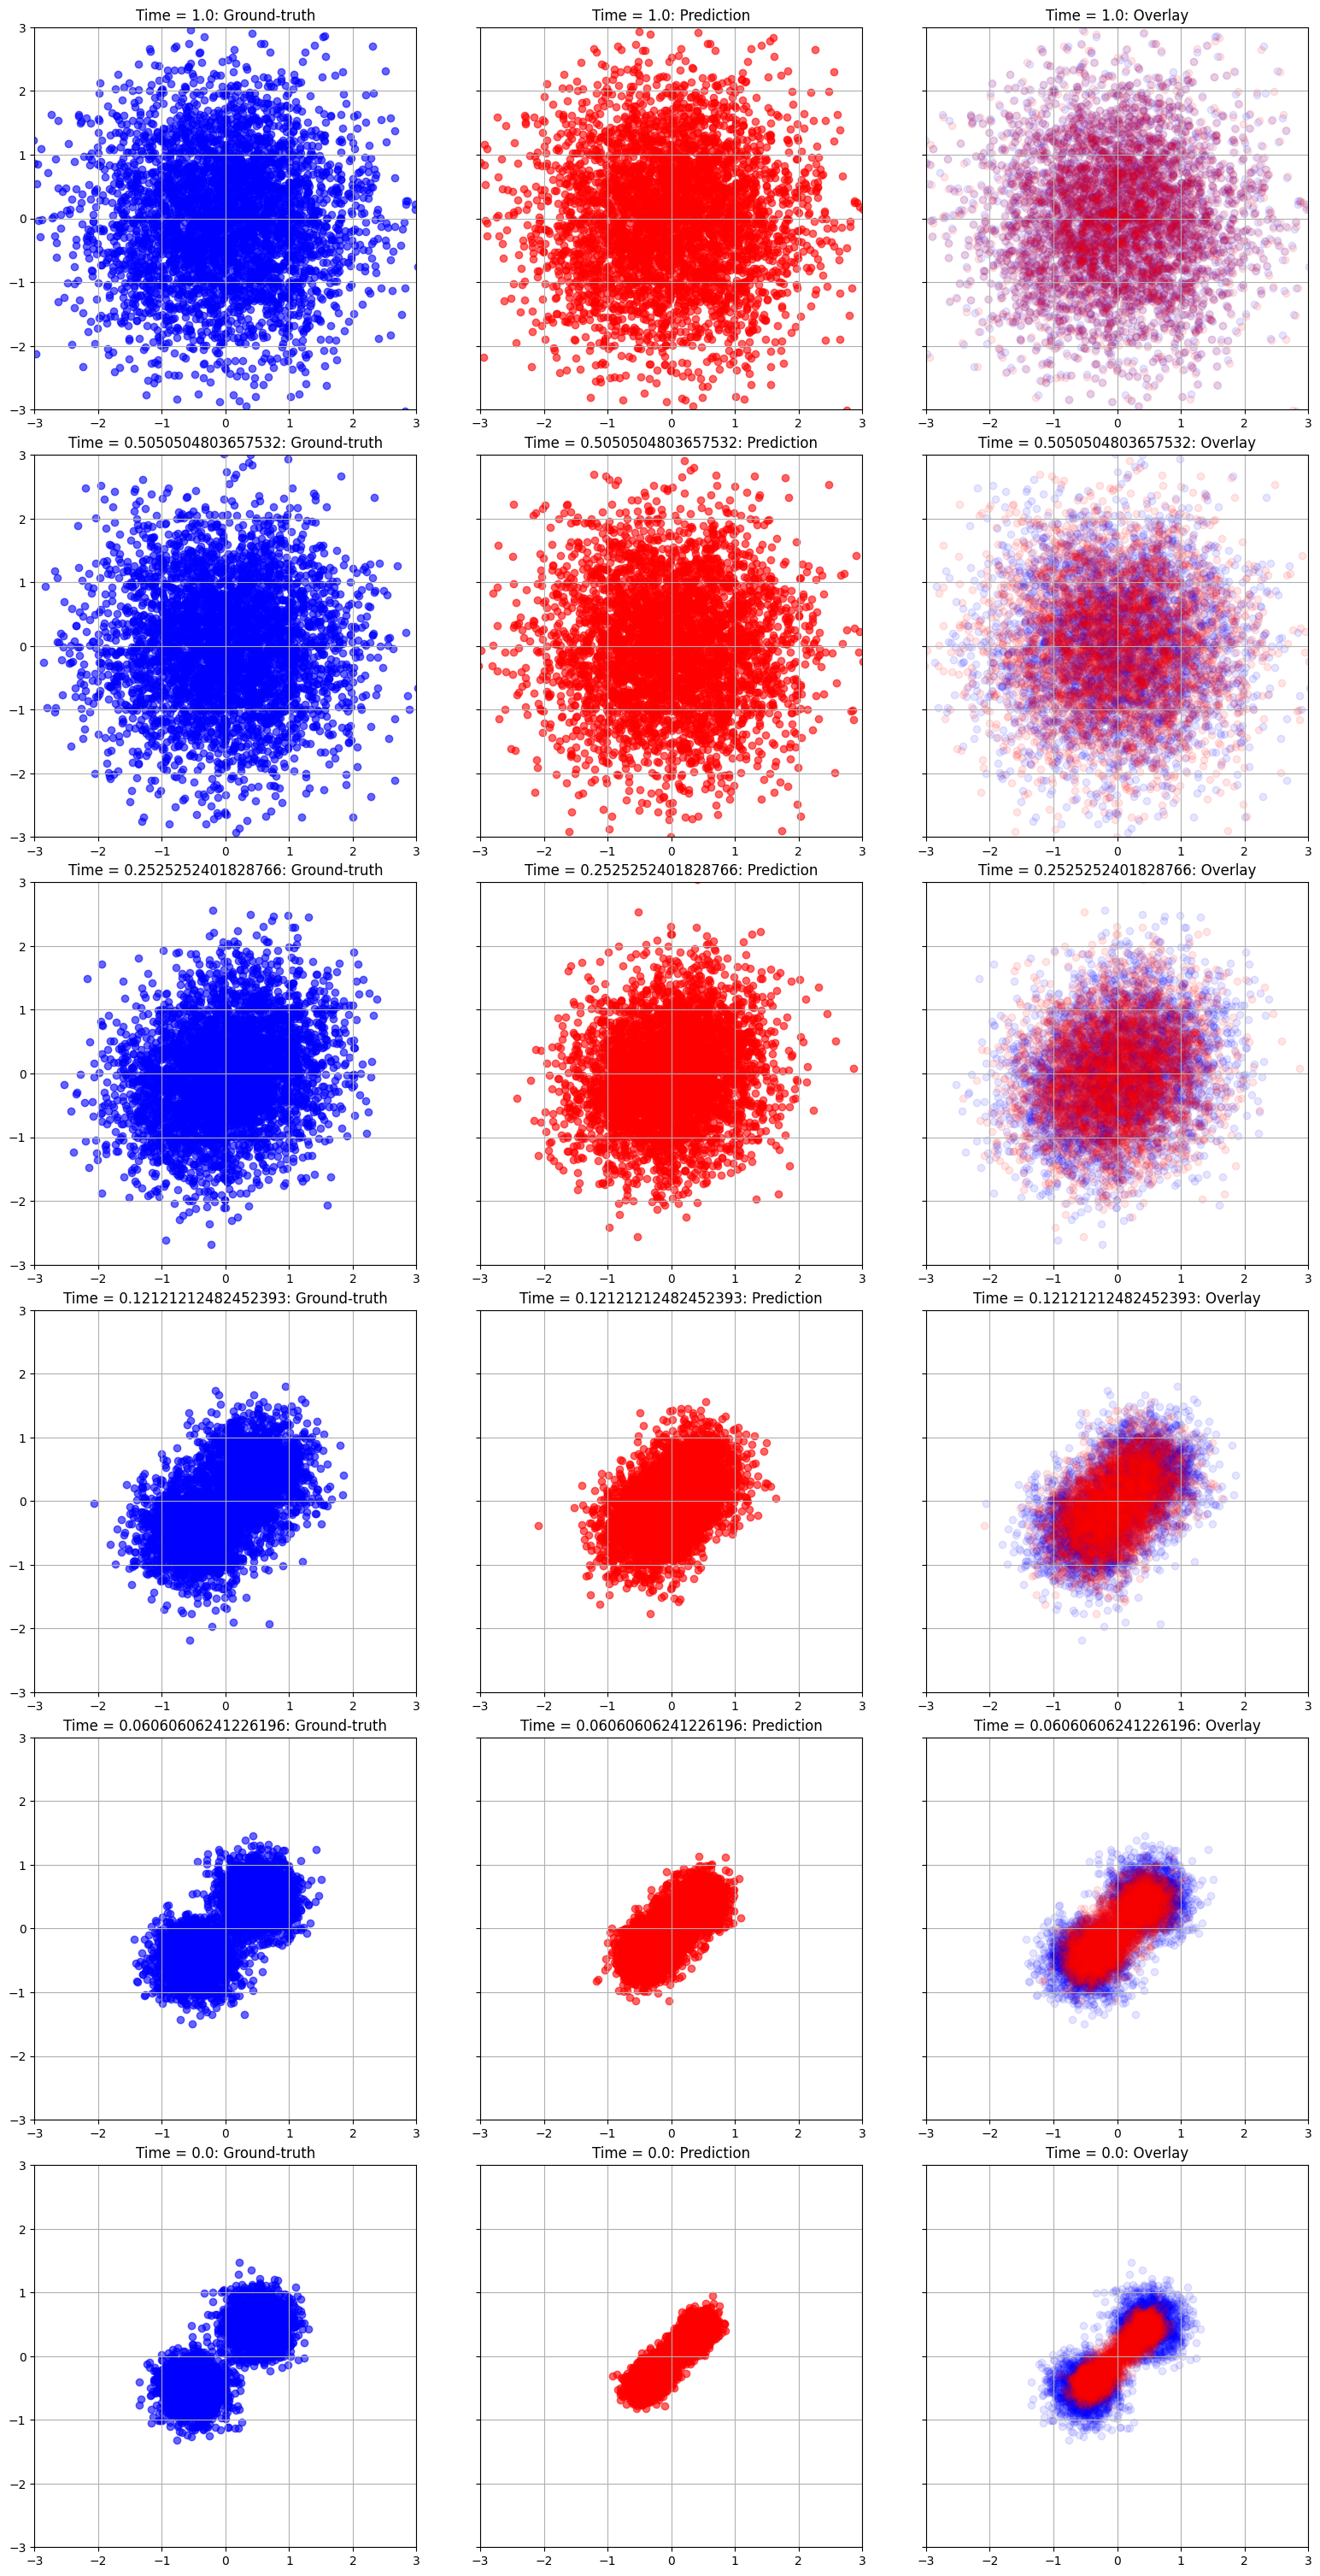

In [16]:

# Select timestamps to visualize
selected_timestamps = [0, T//16, T//8, T//4, T//2, T-1]
#selected_timestamps = [0, 1, 2, 3, 4]
selected_times = [time_vector[t].item() for t in selected_timestamps]

# Plotting the ground-truth and predictions
# fig, axs = plt.subplots(len(selected_timestamps), 2, figsize=(24, 4 * len(selected_timestamps)), sharey=True)
fig, axs = plt.subplots(len(selected_timestamps), 3, figsize=(16, 5 * len(selected_timestamps)), sharey=True)

for j, t in enumerate(selected_timestamps):
    i = len(selected_times) - 1 - j
    # Actual dynamics
    axs[i, 0].scatter(y_test[:, 0, t].cpu().numpy(), y_test[:, 1, t].cpu().numpy(), color='blue', alpha=0.6)
    axs[i, 0].set_xlim(-3, 3)
    axs[i, 0].set_ylim(-3, 3)
    axs[i, 0].set_aspect('equal')
    axs[i, 0].set_title(f'Time = {selected_times[j]}: Ground-truth')
    axs[i, 0].grid(True)

    # Predicted dynamics
    axs[i, 1].scatter(predictions[:, 0, t].cpu().numpy(), predictions[:, 1, t].cpu().numpy(), color='red', alpha=0.6)
    axs[i, 1].set_xlim(-3, 3)
    axs[i, 1].set_ylim(-3, 3)
    axs[i, 1].set_aspect('equal')
    axs[i, 1].set_title(f'Time = {selected_times[j]}: Prediction')
    axs[i, 1].grid(True)

    # Overlay of Ground-truth and Prediction
    axs[i, 2].scatter(y_test[:, 0, t].cpu().numpy(), y_test[:, 1, t].cpu().numpy(), color='blue', alpha=0.1, label='Ground-truth')
    axs[i, 2].scatter(predictions[:, 0, t].cpu().numpy(), predictions[:, 1, t].cpu().numpy(), color='red', alpha=0.1, label='Prediction')
    axs[i, 2].set_xlim(-3, 3)
    axs[i, 2].set_ylim(-3, 3)
    axs[i, 2].set_aspect('equal')
    axs[i, 2].set_title(f'Time = {selected_times[j]}: Overlay')
    axs[i, 2].grid(True)

# plt.suptitle('Comparison of Ground-truth and Predicted Dynamics at Selected Timestamps')
plt.tight_layout(pad=0.2, w_pad=0.3, h_pad=0.5)  # Adjust padding here
plt.savefig("no_sde_marginal")
plt.show()

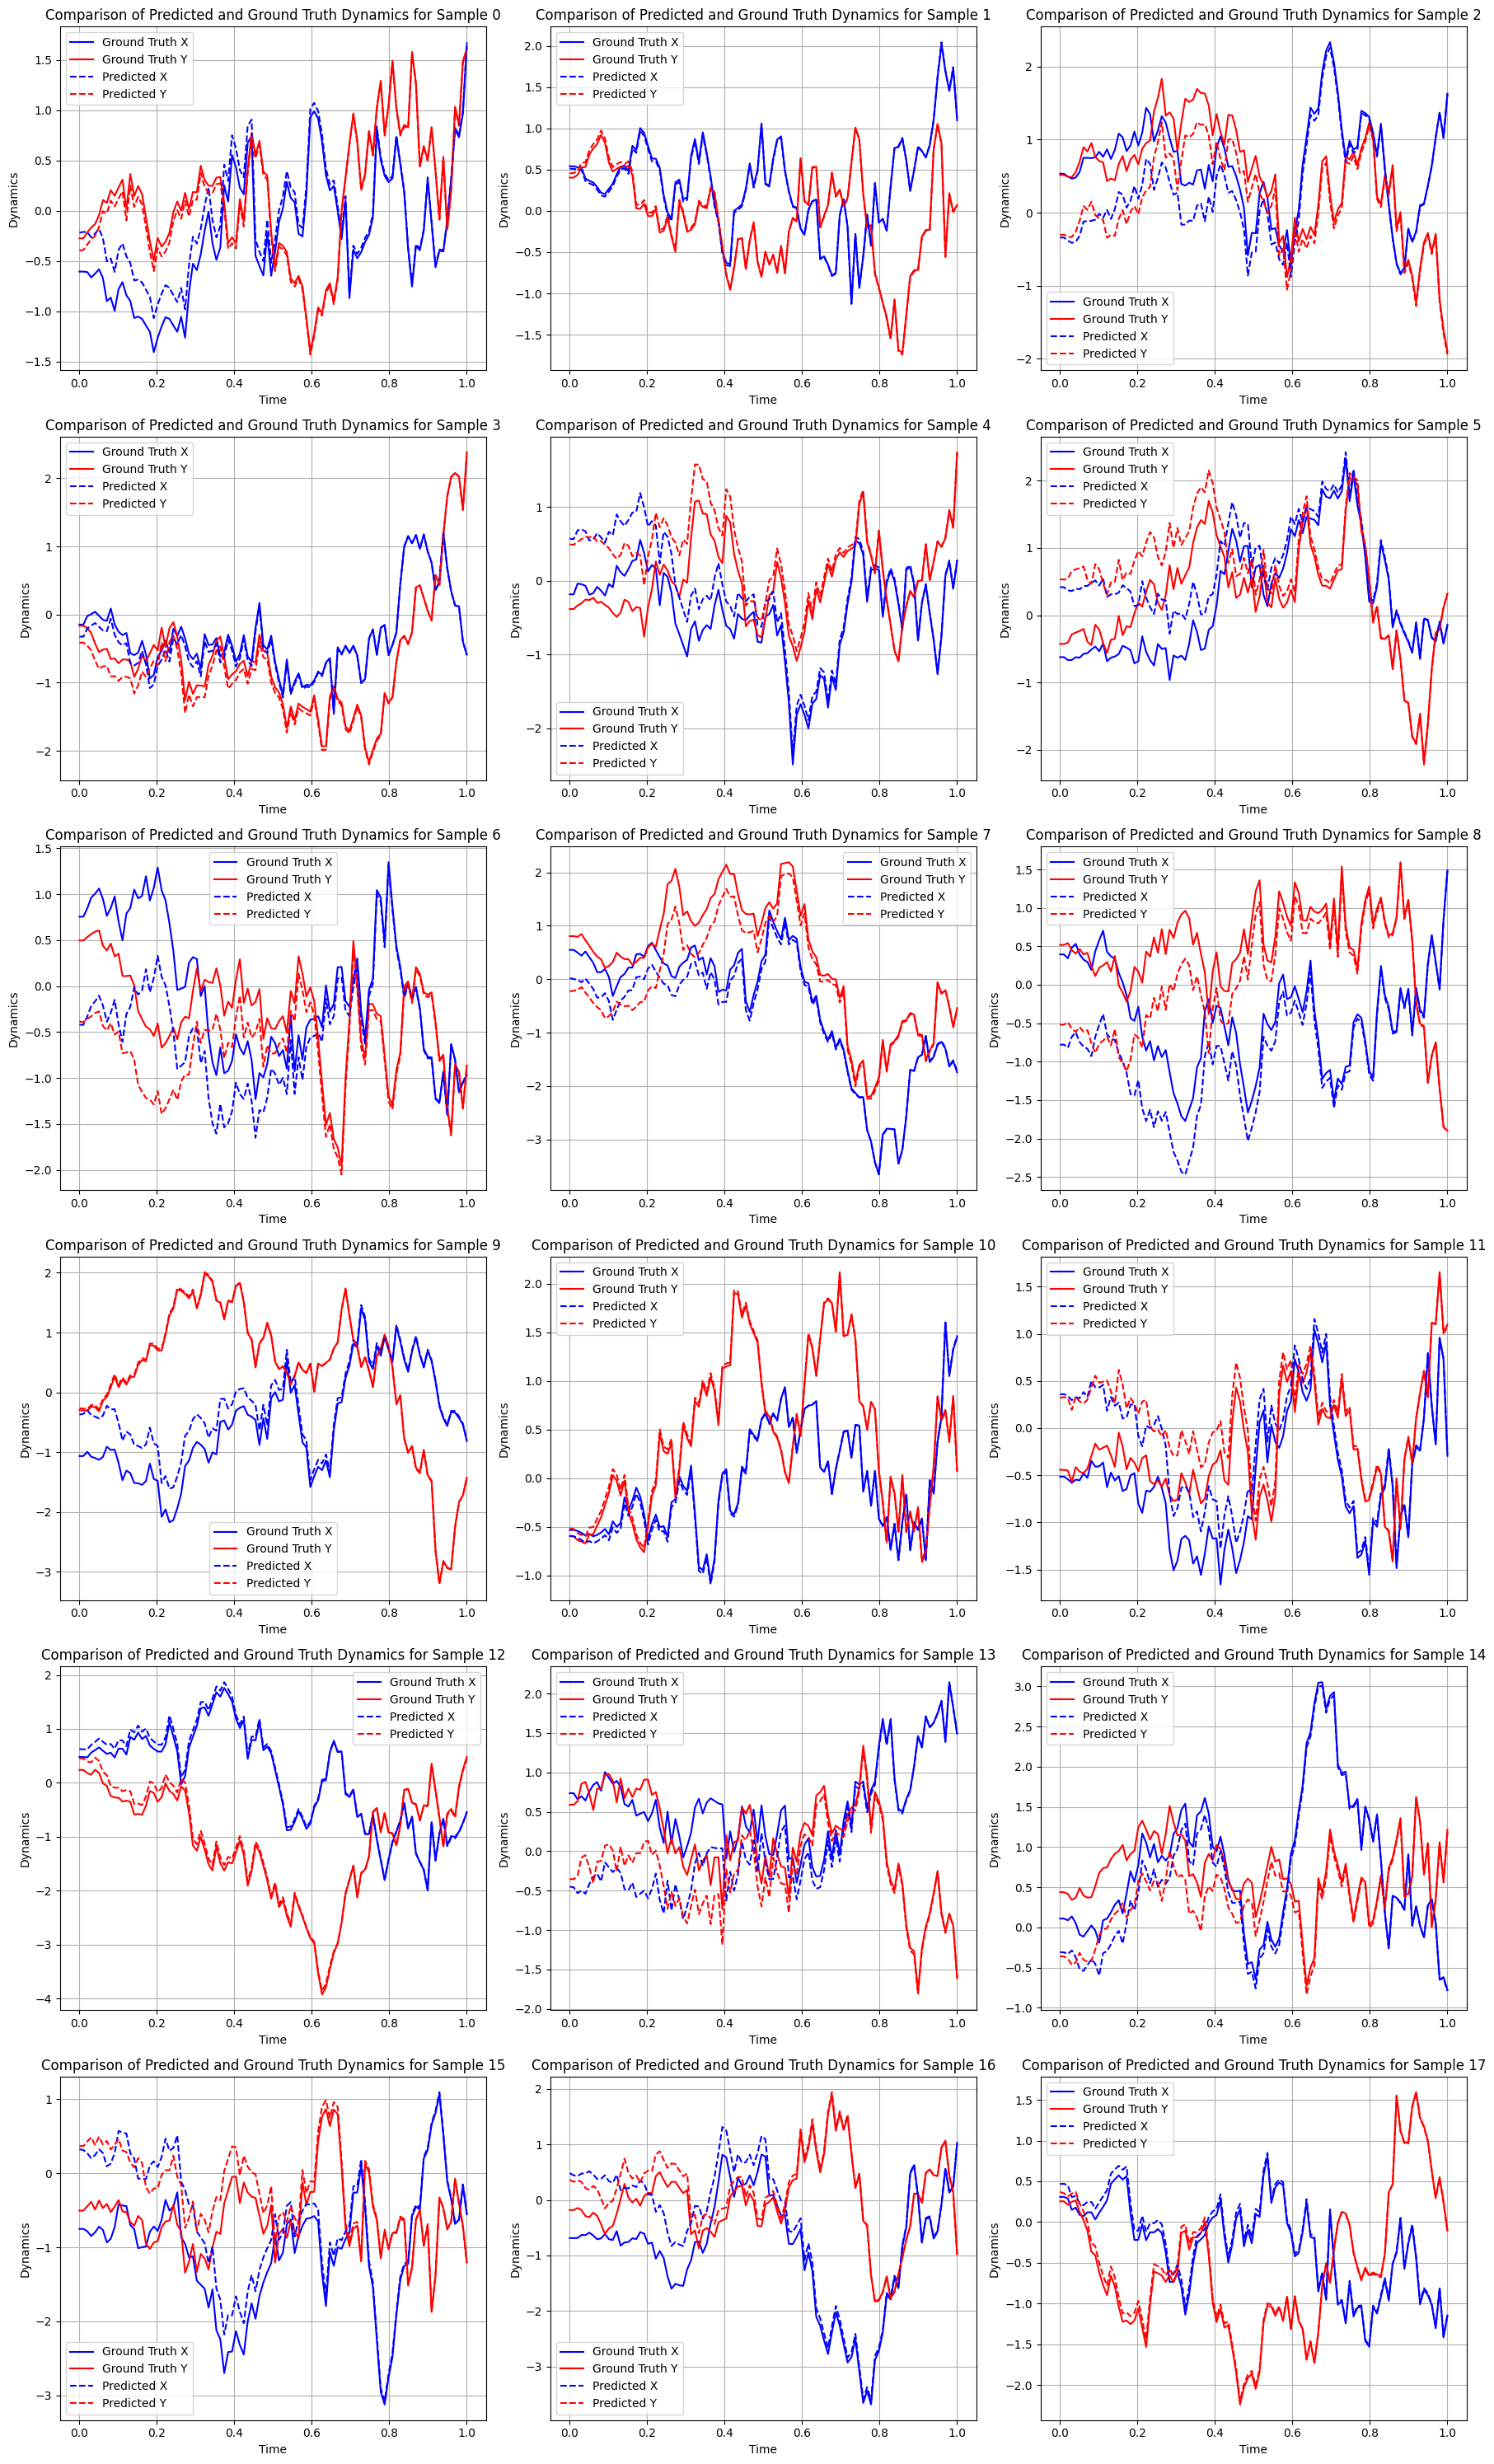

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `predictions` and `y_test` are tensors with dimensions [num_samples, 2, T]
# where `num_samples` is the total number of samples, `2` is for the X and Y coordinates, and `T` is the number of timesteps

# Sample indices to plot
sample_indices = [i for i in range(18)]  # You can modify this list to include any indices you're interested in

# Assuming `time_vector` is a tensor or array that corresponds to time steps, convert it to numpy array
time_steps = time_vector.numpy()  # Adjust this if time_vector is already a numpy array or needs different handling

# Set up the plot with 3 columns
num_columns = 3
num_rows = (len(sample_indices) + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(18, 5 * num_rows))  # Adjust the figure size appropriately

for i, sample_index in enumerate(sample_indices, start=1):
    # Extract the paths for predictions and ground truth for the current sample index
    sample_predictions = predictions[sample_index].cpu().numpy()  # Move data to CPU and convert to numpy if it's a tensor
    sample_ground_truth = y_test[sample_index].cpu().numpy()  # Move data to CPU and convert to numpy if it's a tensor
    
    # Create a subplot for each sample
    plt.subplot(num_rows, num_columns, i)
    plt.plot(time_steps, sample_ground_truth[0, :], label='Ground Truth X', color='blue')
    plt.plot(time_steps, sample_ground_truth[1, :], label='Ground Truth Y', color='red')
    plt.plot(time_steps, sample_predictions[0, :], label='Predicted X', linestyle='--', color='blue')
    plt.plot(time_steps, sample_predictions[1, :], label='Predicted Y', linestyle='--', color='red')

    plt.title(f'Comparison of Predicted and Ground Truth Dynamics for Sample {sample_index}')
    plt.xlabel('Time')
    plt.ylabel('Dynamics')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("no_sde_paths")
plt.show()
